<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1> Machine Learning Problem Formulation</h1>

<h2> Data</h2>

<h3> Data Overview</h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3> Example Data Point</h3>

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

<h2> Mapping the real-world problem to an ML problem</h2>

<h3> Type of Machine Learning Problem</h3>

<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3> Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h3> Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

<h2> Train, CV and Test Datasets</h2>

 Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1> Exploratory Data Analysis</h1>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
# from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


<h2>. Reading Data</h2>

<h3> Reading Gene and Variation Data</h3>

In [4]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3> Reading Text Data</h3>

In [6]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>Preprocessing of text</h3>

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [9]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 171.84262439999998 seconds


In [10]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [12]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [13]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3> Test, Train and Cross Validation Split</h3>

<h4> Splitting data into train, test and cross validation (64:20:16)</h4>

In [14]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [15]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

In [16]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


AttributeError: 'Series' object has no attribute 'sortlevel'

<h2>Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [18]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.531008021438071
Log loss on Test Data using Random Model 2.4986189728115997
-------------------- Confusion matrix --------------------


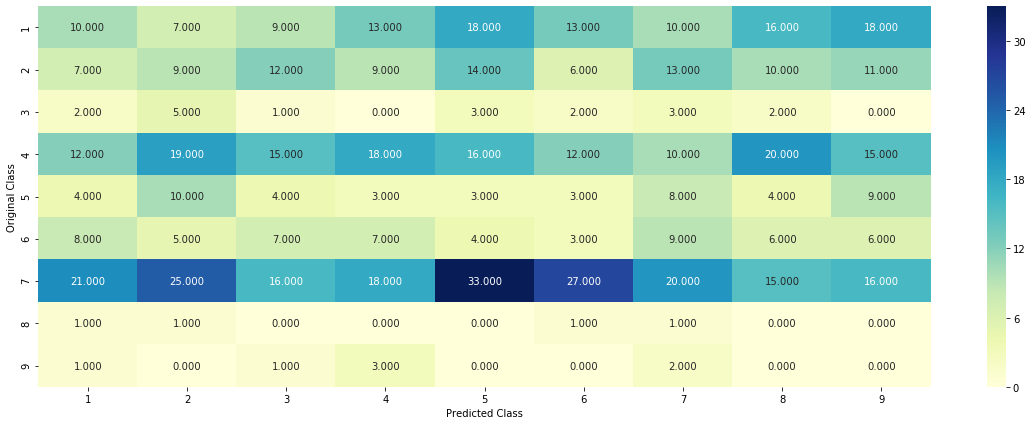

-------------------- Precision matrix (Columm Sum=1) --------------------


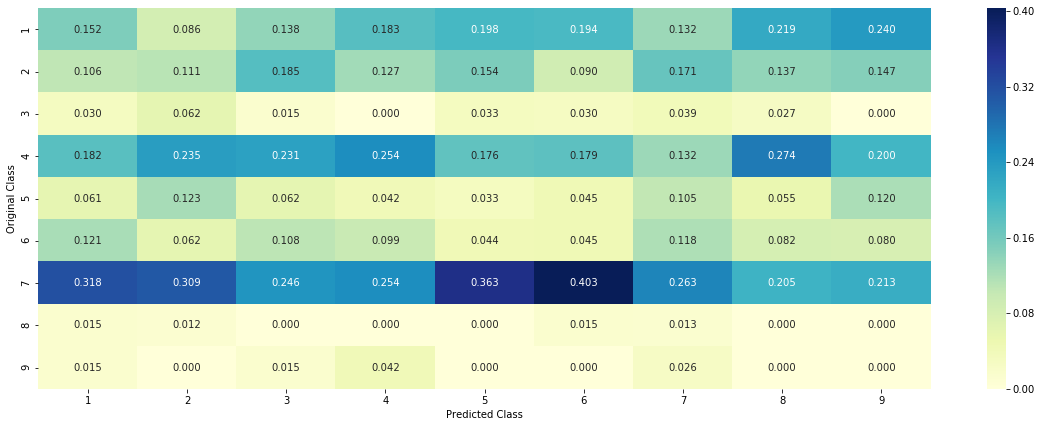

-------------------- Recall matrix (Row sum=1) --------------------


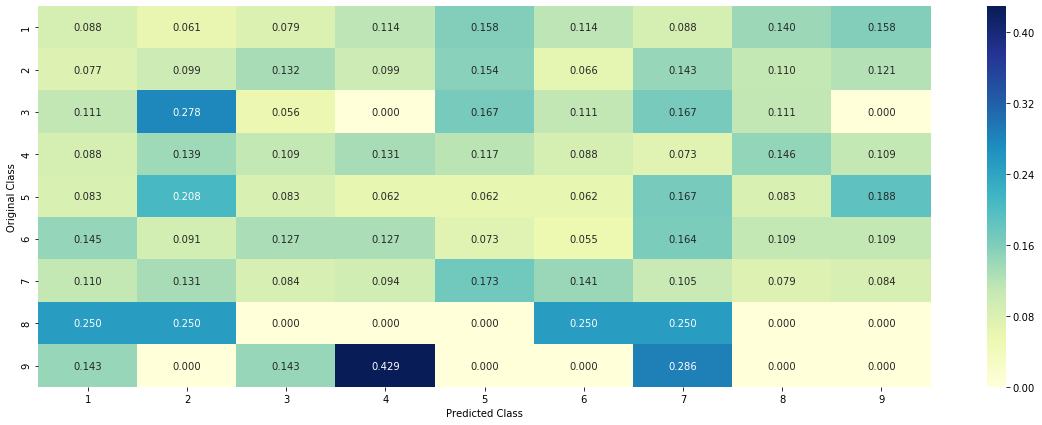

In [19]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h2> Univariate Analysis</h2>

In [20]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h3> Univariate Analysis on Gene Feature</h3>

 Gene is a categorical variable 


In [21]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 239
BRCA1     166
TP53      107
EGFR       94
BRCA2      83
PTEN       78
KIT        66
BRAF       65
PDGFRA     43
ERBB2      40
ALK        40
Name: Gene, dtype: int64


In [22]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 239 different categories of genes in the train data, and they are distibuted as follows


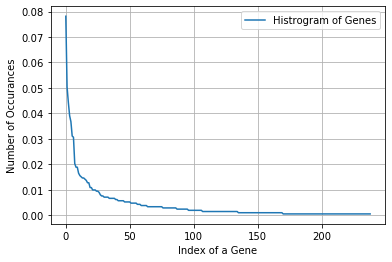

In [23]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


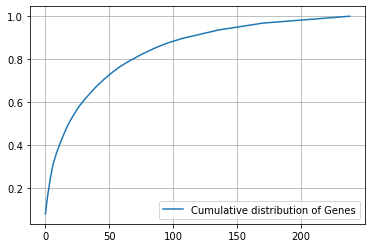

In [24]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;">How to featurize this Gene feature ?</p>

<p style="font-size:16px;">there are two ways we can featurize this variable

<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [25]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [26]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [27]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [29]:
train_df['Gene'].head()

1524      ALK
241      EGFR
2788    BRCA2
3194     NRAS
497      TP53
Name: Gene, dtype: object

In [30]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3

In [31]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 239)


<p style="font-size:18px;">  How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

In [32]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.2318954566712137
For values of alpha =  0.0001 The log loss is: 1.191762497743698
For values of alpha =  0.001 The log loss is: 1.241312397136281
For values of alpha =  0.01 The log loss is: 1.3608060386479532
For values of alpha =  0.1 The log loss is: 1.4736063843045433
For values of alpha =  1 The log loss is: 1.5089131551426727


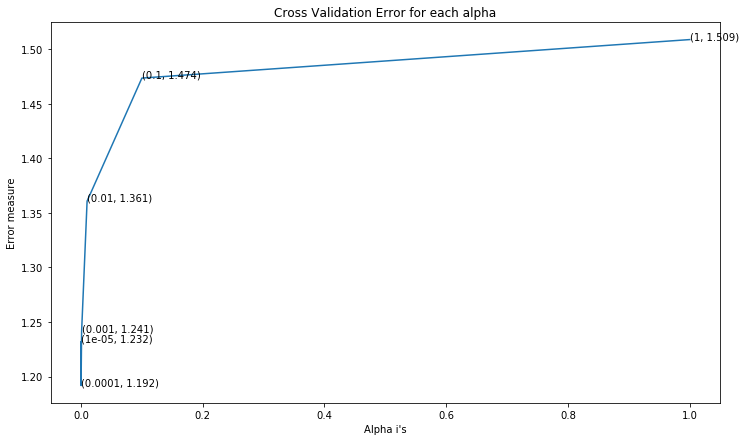

In [33]:
plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_error_array)
for xy in zip(alpha, np.round(cv_log_error_array, 3)):
    plt.annotate(xy, xy)
# plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [34]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                          

In [35]:
predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.9932914188330336
For values of best alpha =  0.0001 The cross validation log loss is: 1.191762497743698
For values of best alpha =  0.0001 The test log loss is: 1.2084597380962028


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [38]:
print("How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":"
      ,(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" 
      ,(cv_coverage/cv_df.shape[0])*100)

How many data points in Test and CV datasets are covered by the  239  genes in train dataset?
Ans
1. In test data 649 out of 665 : 97.59398496240601
2. In cross validation data 517 out of  532 : 97.18045112781954


<h3>Univariate Analysis on Variation Feature</h3>

In [39]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1913
Truncating_Mutations    62
Amplification           50
Deletion                50
Fusions                 23
Overexpression           5
G12V                     4
Q61R                     3
Q61H                     3
G12D                     2
C618R                    2
Name: Variation, dtype: int64


In [40]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1913 different categories of variations in the train data, and they are distibuted as follows


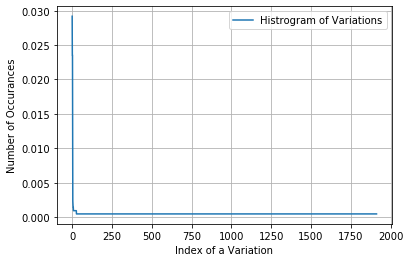

In [41]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02919021 0.0527307  0.07627119 ... 0.99905838 0.99952919 1.        ]


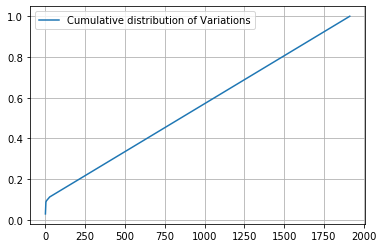

In [42]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [43]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [44]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [45]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [46]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1944)


Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.732382536229955
For values of alpha =  0.0001 The log loss is: 1.7248653898154538
For values of alpha =  0.001 The log loss is: 1.7259711607140713
For values of alpha =  0.01 The log loss is: 1.7346317852803497
For values of alpha =  0.1 The log loss is: 1.7406262515435704
For values of alpha =  1 The log loss is: 1.7423619484550106


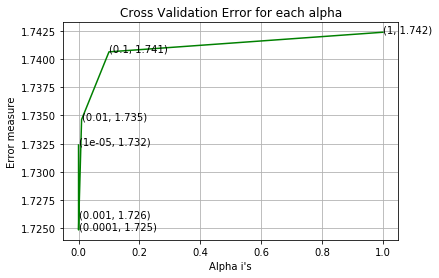

For values of best alpha =  0.0001 The train log loss is: 0.7614497140039461
For values of best alpha =  0.0001 The cross validation log loss is: 1.7248653898154538
For values of best alpha =  0.0001 The test log loss is: 1.7146977344802132


In [47]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [48]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1913  genes in test and cross validation data sets?
Ans
1. In test data 68 out of 665 : 10.225563909774436
2. In cross validation data 36 out of  532 : 6.7669172932330826


<h3> Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [49]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [50]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [61]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3,max_features=1000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and
# returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with 
# its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [62]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [63]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [64]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T
# matx = [[1, 2],
#        [3, 4]]
# matx.T = [[1, 3],
#           [2, 4]]
# matx.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two diamensional array
# matx.sum(axix =1) = [[3, 7]]
# (matx.T)/(matx.sum(axis=1)) = [[1/3, 3/7]
#                               [2/3, 4/7]]

# (matx.T)/(matx.sum(axis=1)).T = [[1/3, 2/3]
#                                  [3/7, 4/7]]
# sum of row elements = 1

In [65]:
print("Size of response coded text feature of Train Data = "+str(train_text_feature_responseCoding.shape))
print("Size of response coded text feature of Test Data = "+str(test_text_feature_responseCoding.shape))
print("Size of response coded text feature of CV Data = "+str(cv_text_feature_responseCoding.shape))

Size of response coded text feature of Train Data = (2124, 9)
Size of response coded text feature of Test Data = (665, 9)
Size of response coded text feature of CV Data = (532, 9)


In [73]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

How are word frequencies distributed?

In [74]:
#https://stackoverflow.com/a/2258273/4084039
# sorting by values
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), 
                                   key=lambda x: x[1] , reverse=True))
# words and their occuence
print(sorted_text_fea_dict)
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))
print(sorted_text_occur)

{'mutations': 153194, 'cells': 121243, 'cell': 82896, 'fig': 68234, 'mutation': 67701, 'et': 66916, 'al': 66810, 'cancer': 64966, 'figure': 62988, 'patients': 56788, 'protein': 54697, 'expression': 51138, 'activity': 48588, 'mutant': 47136, 'type': 46891, 'tumor': 45049, 'also': 43034, 'kinase': 42385, 'domain': 41560, 'variants': 41092, 'using': 40992, 'gene': 40105, 'binding': 39923, 'data': 39061, 'brca1': 38299, 'analysis': 38297, 'egfr': 36931, 'wild': 36734, 'dna': 36627, '10': 36524, 'tumors': 35178, 'two': 33883, 'table': 33693, 'mutants': 33533, 'activation': 32604, 'may': 31877, 'results': 29597, 'shown': 28729, 'ras': 27969, 'genes': 26839, 'one': 26527, 'p53': 26500, 'proteins': 26394, 'associated': 26144, 'exon': 25970, 'used': 24957, 'kit': 24938, 'growth': 24913, 'human': 24803, 'identified': 24642, 'found': 24439, 'study': 24274, 'function': 24035, 'clinical': 22859, 'signaling': 22730, '20': 22539, 'levels': 22497, 'lines': 22004, 'observed': 21255, 'functional': 21074

In [75]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5873, 4: 3441, 5: 3278, 6: 2862, 9: 2018, 8: 1924, 7: 1856, 12: 1602, 10: 1558, 15: 1052, 11: 935, 13: 906, 14: 867, 16: 725, 18: 718, 20: 693, 17: 585, 21: 535, 24: 533, 19: 481, 22: 422, 27: 418, 25: 416, 42: 387, 30: 385, 23: 366, 28: 342, 26: 335, 44: 326, 33: 310, 36: 286, 31: 283, 32: 272, 40: 262, 29: 261, 34: 249, 35: 239, 37: 229, 45: 204, 48: 200, 38: 199, 39: 184, 43: 179, 41: 168, 50: 164, 46: 163, 60: 158, 49: 158, 54: 151, 57: 149, 47: 149, 53: 148, 56: 147, 55: 141, 66: 136, 51: 133, 52: 125, 80: 118, 61: 118, 59: 117, 65: 114, 63: 113, 58: 112, 64: 110, 68: 109, 62: 104, 72: 100, 67: 92, 78: 88, 76: 88, 69: 88, 70: 87, 88: 84, 77: 82, 71: 81, 73: 80, 84: 79, 75: 78, 83: 76, 81: 76, 86: 75, 100: 74, 91: 71, 90: 70, 110: 68, 95: 66, 87: 65, 85: 65, 94: 64, 82: 63, 74: 63, 79: 62, 96: 58, 92: 57, 105: 56, 93: 56, 144: 55, 107: 53, 89: 53, 97: 52, 120: 51, 111: 50, 104: 50, 101: 50, 99: 50, 113: 49, 106: 49, 112: 48, 102: 48, 115: 47, 98: 47, 126: 46, 117: 45, 1

In [76]:

alpha = [10 ** x for x in range(-5, 1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))



For values of alpha =  1e-05 The log loss is: 1.3777975205537372
For values of alpha =  0.0001 The log loss is: 1.2431151089465338
For values of alpha =  0.001 The log loss is: 1.241747896394446
For values of alpha =  0.01 The log loss is: 1.326676911071675
For values of alpha =  0.1 The log loss is: 1.4469664545467111
For values of alpha =  1 The log loss is: 1.655306924398241


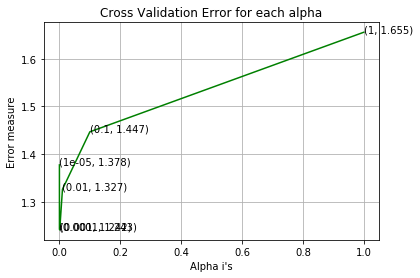

For values of best alpha =  0.001 The train log loss is: 0.7081940304387215
For values of best alpha =  0.001 The cross validation log loss is: 1.241747896394446
For values of best alpha =  0.001 The test log loss is: 1.0514029063132313


In [77]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [78]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [79]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.834 % of word of test data appeared in train data
98.449 % of word of Cross Validation appeared in train data


<h1>Machine Learning Models</h1>

In [82]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [83]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))




In [84]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [85]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56523)
(number of data points * number of features) in test data =  (665, 56523)
(number of data points * number of features) in cross validation data = (532, 56523)


In [86]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [238]:
table = pd.DataFrame(columns = ["Model", "Train Log-loss", 
                                "CV Log-loss", "Test Log-loss",
                                "Mis-Classified CV",
                                "Mis-Classified Test"
                               ,"Best HyperParameter"])
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter


<h2> Base Line Model</h2>

<h3> Naive Bayes</h3>

<h4> Hyper parameter tuning</h4>

In [87]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



for alpha = 1e-05
Log Loss : 1.3459455551433697
for alpha = 0.0001
Log Loss : 1.3513351140765935
for alpha = 0.001
Log Loss : 1.3452981266846882
for alpha = 0.1
Log Loss : 1.319835911993243
for alpha = 1
Log Loss : 1.3837835452541087
for alpha = 10
Log Loss : 1.4711635655968507
for alpha = 100
Log Loss : 1.4616832004619689
for alpha = 1000
Log Loss : 1.4281321393615782


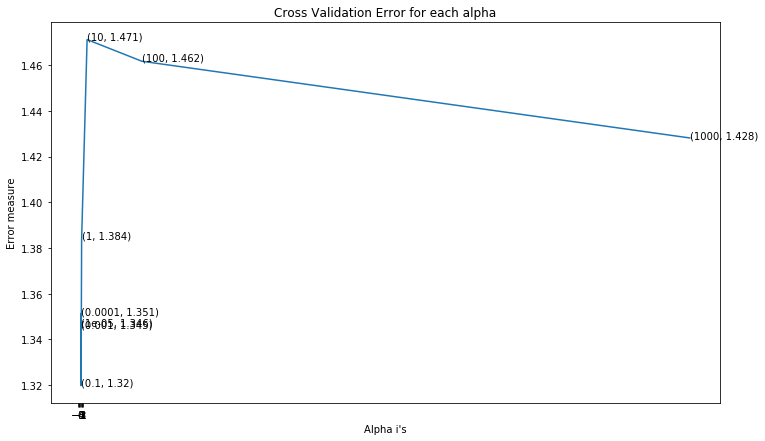

In [89]:

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_error_array)
for xy in zip(alpha, np.round(cv_log_error_array, 3)):
    plt.annotate(xy, xy)
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [90]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=0.1, class_prior=None,
                                                    fit_prior=True),
                       cv='warn', method='sigmoid')

In [91]:

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.882777381166603
For values of best alpha =  0.1 The cross validation log loss is: 1.319835911993243
For values of best alpha =  0.1 The test log loss is: 1.2268278537855588


In [239]:
table = table.append(pd.DataFrame([["Naive Bayes", 0.8827, 1.3198, 1.2268, "41.75%", "37.44%", "0.1"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1


<h4> Testing the model with best hyper paramters</h4>

In [130]:
def predict_and_plot_confusion_matrix(cv_x,cv_y,train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
#     pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(cv_y, sig_clf.predict_proba(cv_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", 
          np.count_nonzero((sig_clf.predict(cv_x)- cv_y))/cv_y.shape[0])
    print("Number of mis-classified points :", 
          np.count_nonzero((sig_clf.predict(test_x)- test_y))/test_y.shape[0])
    
    plot_confusion_matrix(cv_y, sig_clf.predict(cv_x))
    plot_confusion_matrix(test_y, sig_clf.predict(test_x))

In [81]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

Log Loss : 1.319835911993243
Number of missclassified point for CV points : 0.41729323308270677
Percentage of mis-classified for Test points =  0.3744360902255639
-------------------- Confusion matrix --------------------


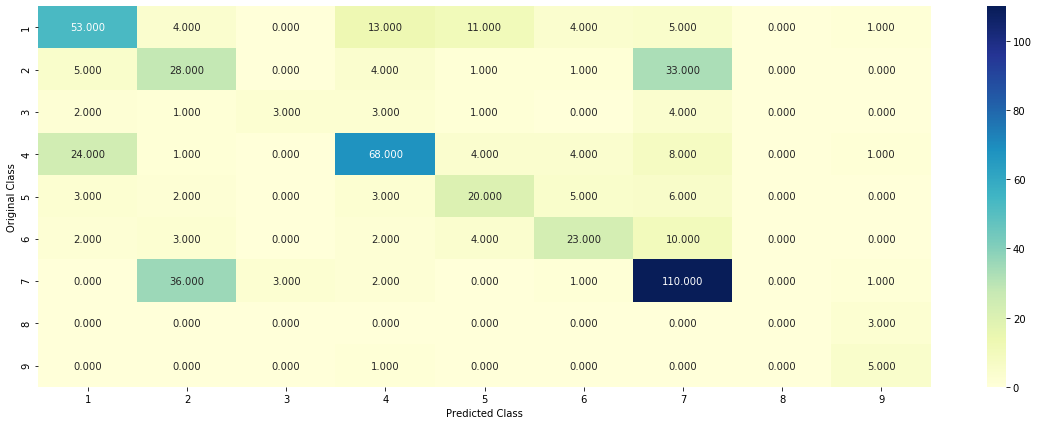

-------------------- Precision matrix (Columm Sum=1) --------------------


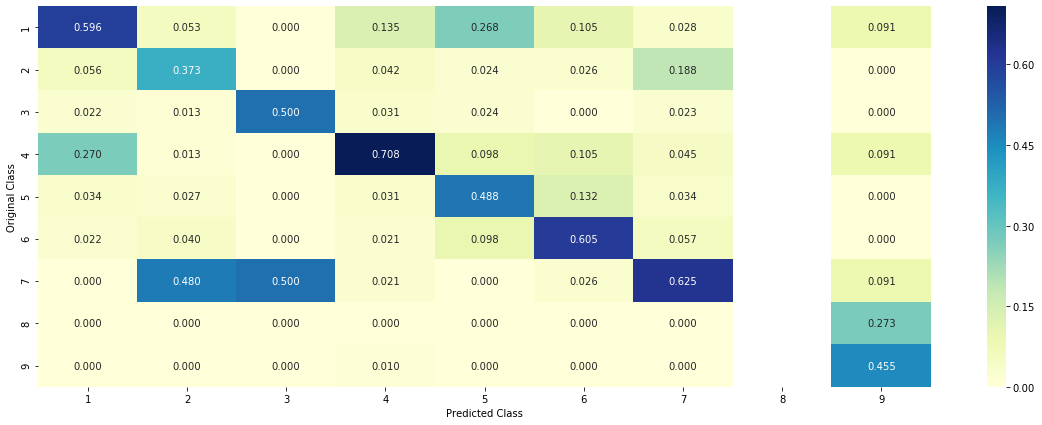

-------------------- Recall matrix (Row sum=1) --------------------


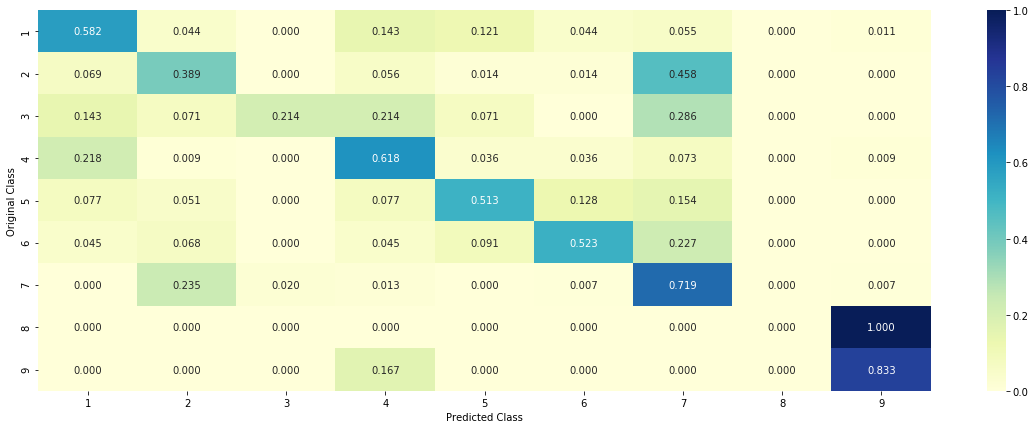

In [97]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites
# we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
# print(sig_clf.predict(cv_x_onehotCoding)- cv_y)
# print(cv_y.shape[0])
print("Number of missclassified point for CV points :"
      , np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
print("Percentage of mis-classified for Test points = ",
      np.count_nonzero((sig_clf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

-------------------- Confusion matrix --------------------


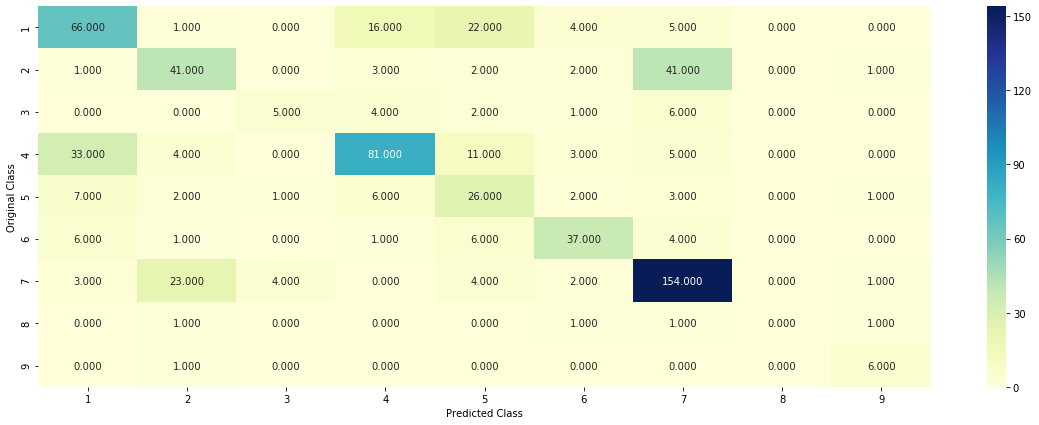

-------------------- Precision matrix (Columm Sum=1) --------------------


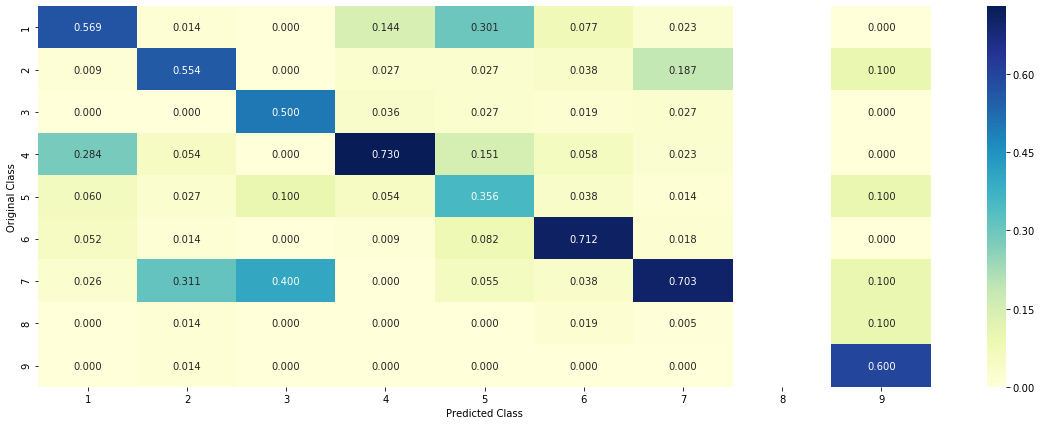

-------------------- Recall matrix (Row sum=1) --------------------


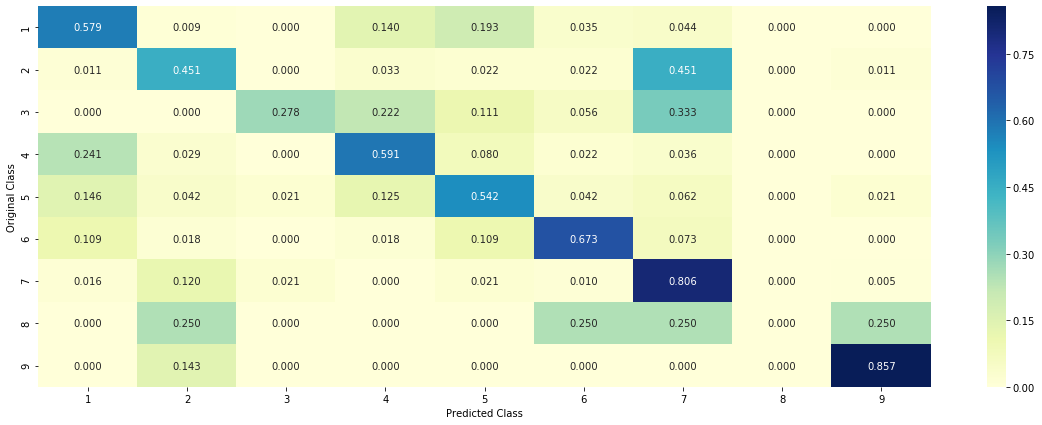

In [98]:
plot_confusion_matrix(test_y, sig_clf.predict(test_x_onehotCoding.toarray()))

<h4> Feature Importance, Correctly classified point</h4>

In [102]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", 
      np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
# coef feature weight
indices=np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0],
                     test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0807 0.0674 0.0171 0.0945 0.04   0.0369 0.6565 0.0034 0.0035]]
Actual Class : 7
--------------------------------------------------
17 Text feature [presence] present in test data point [True]
18 Text feature [kinase] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [independent] present in test data point [True]
21 Text feature [activating] present in test data point [True]
22 Text feature [well] present in test data point [True]
23 Text feature [contrast] present in test data point [True]
25 Text feature [cell] present in test data point [True]
26 Text feature [previously] present in test data point [True]
27 Text feature [shown] present in test data point [True]
28 Text feature [treated] present in test data point [True]
29 Text feature [cells] present in test data point [True]
30 Text feature [mutations] present in test data point [True]
31 Text feature [inhibitor] 

<h4> Feature Importance, Incorrectly classified point</h4>

In [103]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.1104 0.0927 0.0234 0.1303 0.4027 0.0504 0.1803 0.0047 0.0051]]
Actual Class : 4
--------------------------------------------------
6 Text feature [neutral] present in test data point [True]
7 Text feature [gvgd] present in test data point [True]
8 Text feature [assays] present in test data point [True]
9 Text feature [cooccurrence] present in test data point [True]
14 Text feature [nhgri] present in test data point [True]
15 Text feature [r1699q] present in test data point [True]
16 Text feature [align] present in test data point [True]
17 Text feature [functional] present in test data point [True]
18 Text feature [variants] present in test data point [True]
19 Text feature [evolutionarily] present in test data point [True]
20 Text feature [agvgd] present in test data point [True]
22 Text feature [v1736a] present in test data point [True]
23 Text feature [uncertain] present in test data point [True]
24 Text feature [article] presen

<h2> K Nearest Neighbour Classification</h2>

<h3> Hyper parameter tuning</h3>

USing response encoding

for alpha = 3
Log Loss : 1.1375256147570272
for alpha = 5
Log Loss : 1.1440587677463063
for alpha = 11
Log Loss : 1.1342473763113563
for alpha = 15
Log Loss : 1.136768406600477
for alpha = 21
Log Loss : 1.1330978451898945
for alpha = 31
Log Loss : 1.1254928358259368
for alpha = 41
Log Loss : 1.1329532766968173
for alpha = 51
Log Loss : 1.1299906592783528
for alpha = 99
Log Loss : 1.1469303234294457
for alpha = 121
Log Loss : 1.1661895407386111


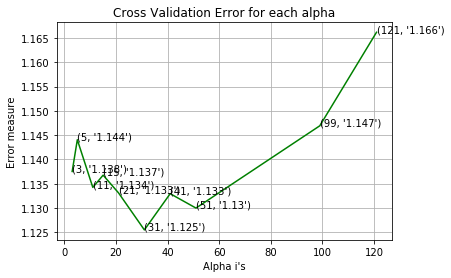

For values of best alpha =  31 The train log loss is: 0.7986747885854074
For values of best alpha =  31 The cross validation log loss is: 1.1254928358259368
For values of best alpha =  31 The test log loss is: 1.0357605567846981


In [132]:
alpha = [3, 5, 11, 15, 21, 31, 41, 51, 99,121]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [240]:
table = table.append(pd.DataFrame([["KNN", 0.7986, 1.1254, 1.0257, "39.84%", "37.59%", "31"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1
0,KNN,0.7986,1.1254,1.0257,39.84%,37.59%,31


<h3> Testing the model with best hyper paramters</h3>

Log loss : 1.1254928358259368
Number of mis-classified points : 0.39849624060150374
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


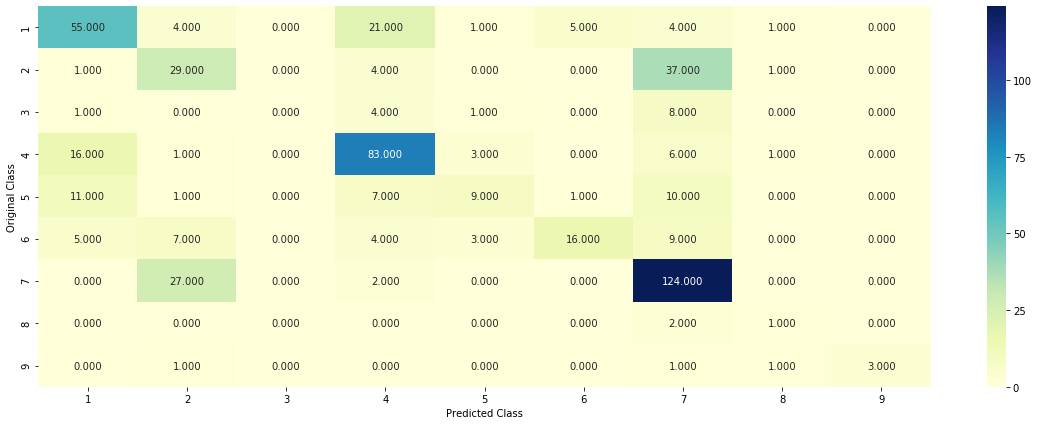

-------------------- Precision matrix (Columm Sum=1) --------------------


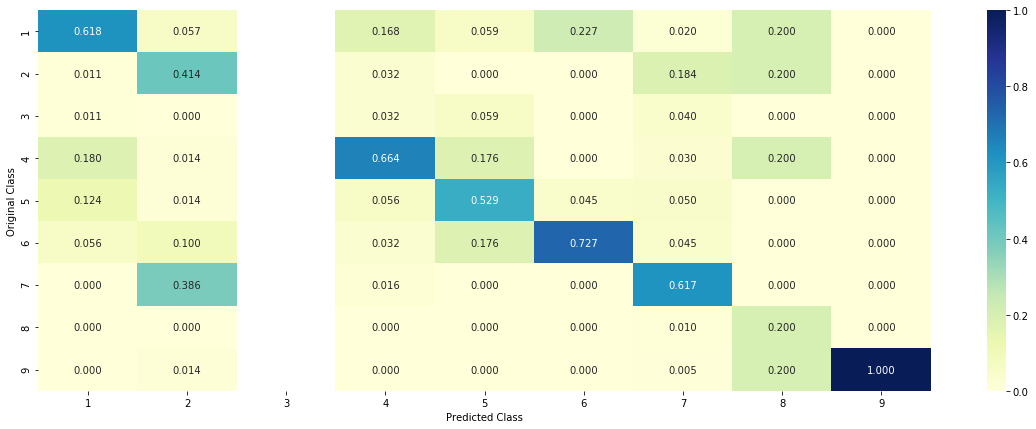

-------------------- Recall matrix (Row sum=1) --------------------


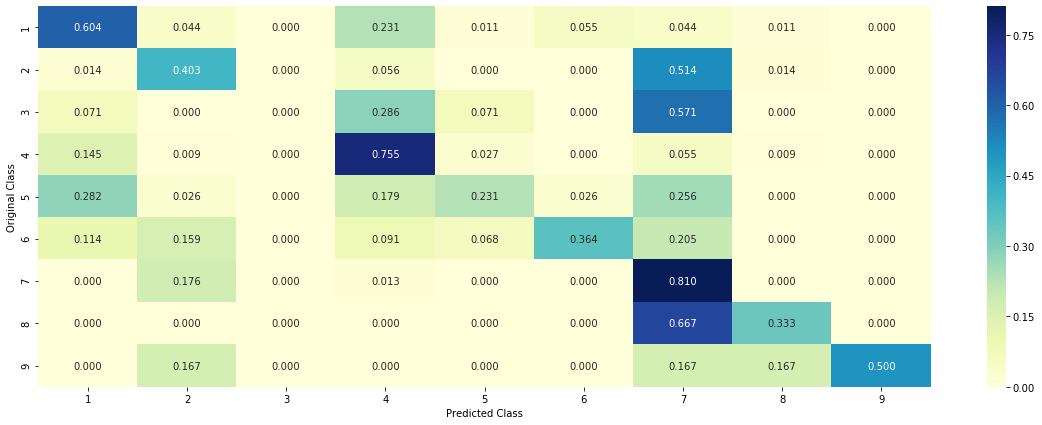

-------------------- Confusion matrix --------------------


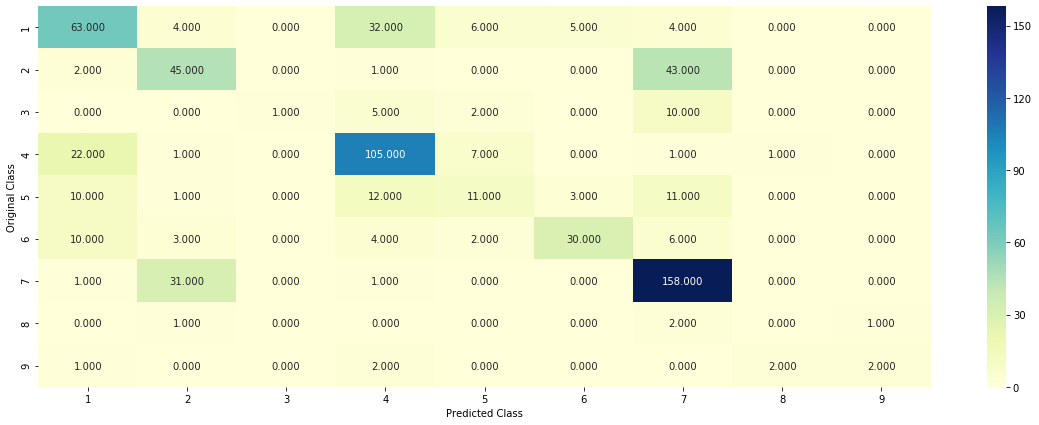

-------------------- Precision matrix (Columm Sum=1) --------------------


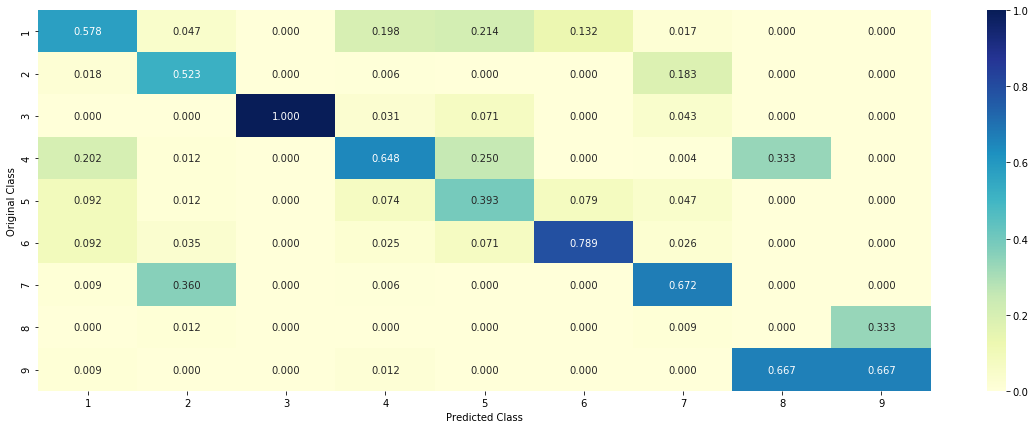

-------------------- Recall matrix (Row sum=1) --------------------


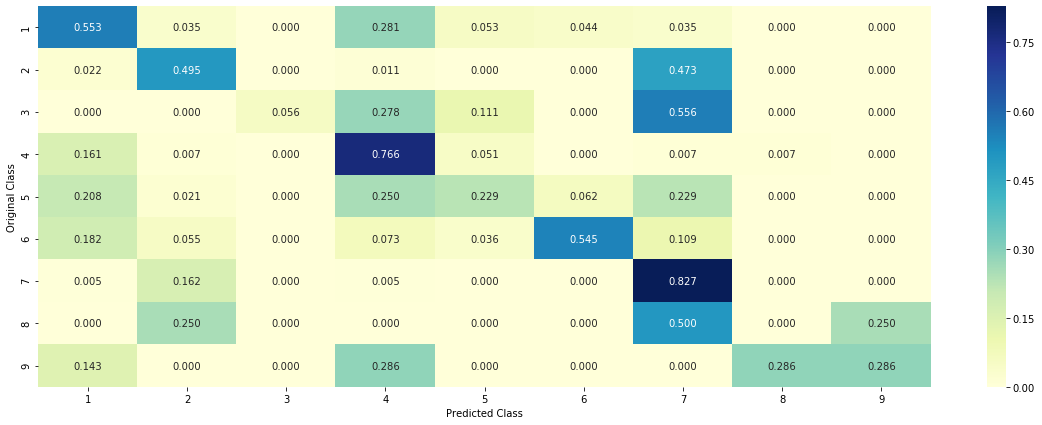

In [133]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
# cv_x,cv_y,train_x, train_y,test_x, test_y, clf
predict_and_plot_confusion_matrix(cv_x_responseCoding,cv_y,
                                  train_x_responseCoding,train_y, 
                                  test_x_responseCoding, test_y, clf)

<h3>.Sample Query point -1</h3>

In [137]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 35

predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 6
The  31  nearest neighbours of the test points belongs to classes [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5]
Fequency of nearest points : Counter({6: 28, 5: 3})


<h3> Sample Query Point-2 </h3>

In [139]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 2

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 31 and the nearest neighbours of the test points belongs to classes [7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 2 2 7 7 7 2 2 2 7 7 7 7 2]
Fequency of nearest points : Counter({7: 24, 2: 7})


<h2> Logistic Regression</h2>

<h3> With Class balancing</h3>

<h4> Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.3865677217203687
for alpha = 1e-05
Log Loss : 1.3684472707221578
for alpha = 0.0001
Log Loss : 1.2097085340018523
for alpha = 0.001
Log Loss : 1.1659345510691084
for alpha = 0.01
Log Loss : 1.201935207121487
for alpha = 0.1
Log Loss : 1.5071751779580238
for alpha = 1
Log Loss : 1.7268836371592693
for alpha = 10
Log Loss : 1.7497324713869005
for alpha = 100
Log Loss : 1.7519963900552449
for alpha = 1000
Log Loss : 1.752262721221051


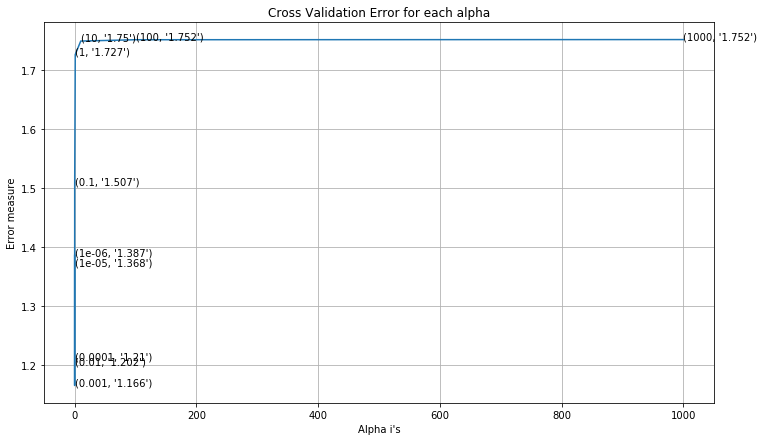

For values of best alpha =  0.001 The train log loss is: 0.5787341566748393
For values of best alpha =  0.001 The cross validation log loss is: 1.1659345510691084
For values of best alpha =  0.001 The test log loss is: 0.9792639886980169


In [141]:
alpha = [10 ** x for x in range(-6, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots(figsize = (12, 7))
ax.plot(alpha, cv_log_error_array)
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
# plt.grid()
# fig.
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [241]:
table = table.append(pd.DataFrame([["Logistic Regresion(Balanced) + BOW", 0.5787, 1.1659, 0.9792, "37.59%", "37.74%", "0.001"]],
                                  columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1
0,KNN,0.7986,1.1254,1.0257,39.84%,37.59%,31
0,Logistic Regresion(Balanced) + BOW,0.5787,1.1659,0.9792,37.59%,37.74%,0.001


<h4> Testing the model with best hyper paramters</h4>

Log loss : 1.0143386482669865
Number of mis-classified points : 0.37593984962406013
Number of mis-classified points : 0.3774436090225564
-------------------- Confusion matrix --------------------


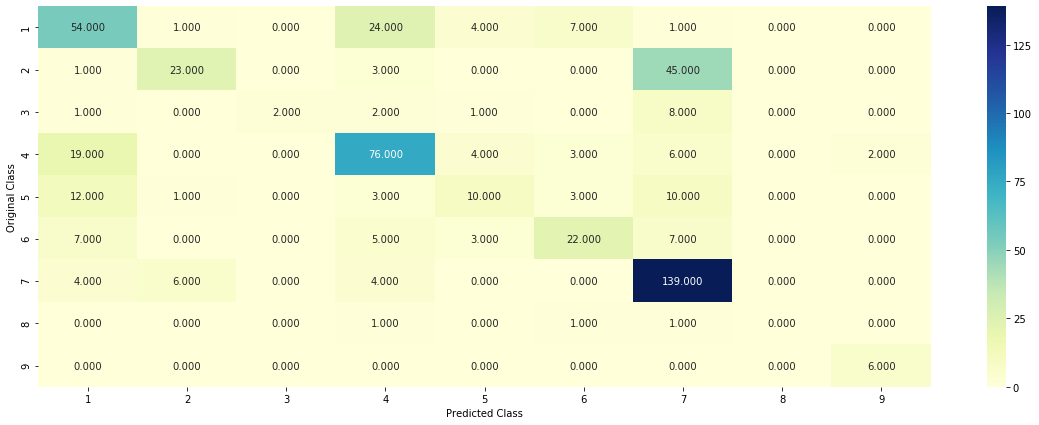

-------------------- Precision matrix (Columm Sum=1) --------------------


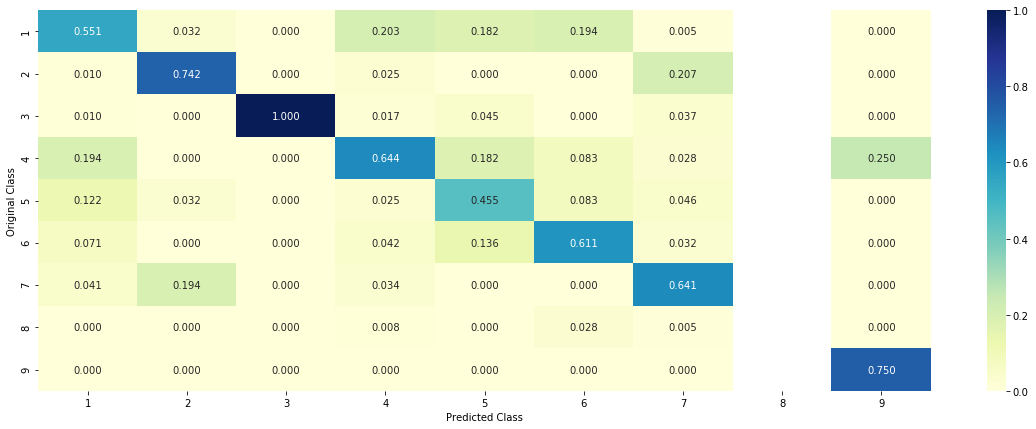

-------------------- Recall matrix (Row sum=1) --------------------


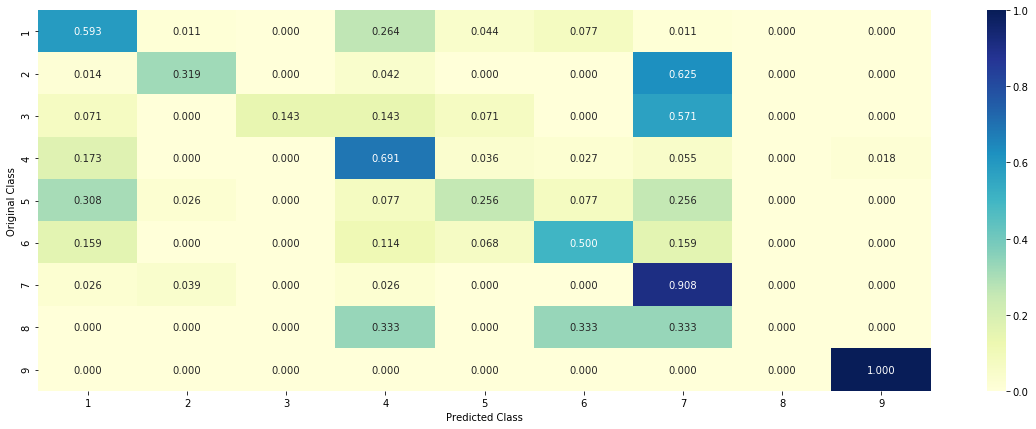

-------------------- Confusion matrix --------------------


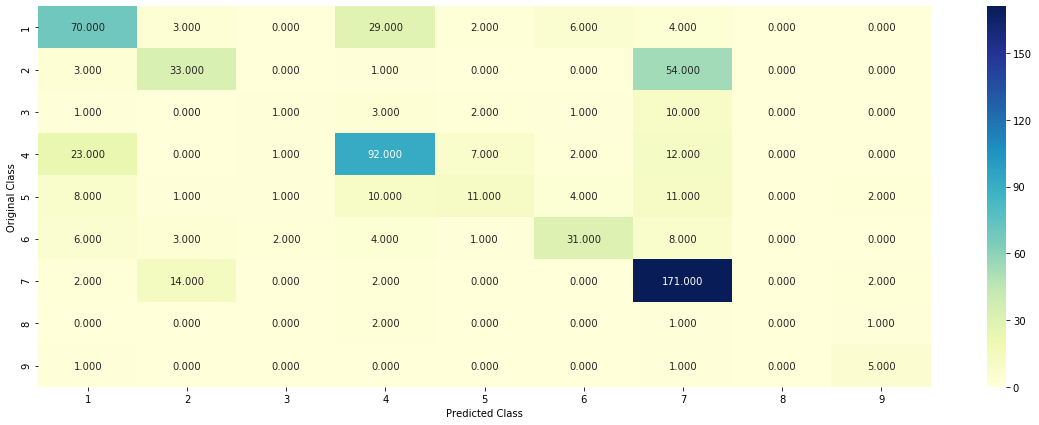

-------------------- Precision matrix (Columm Sum=1) --------------------


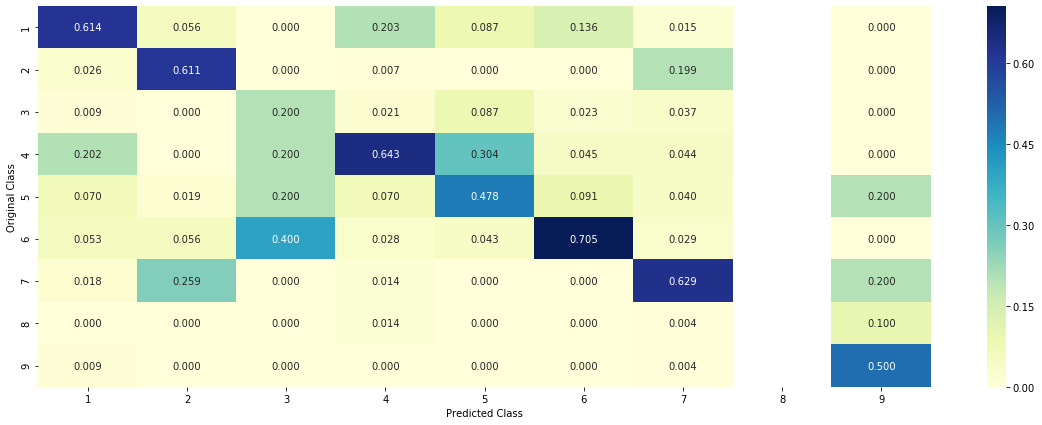

-------------------- Recall matrix (Row sum=1) --------------------


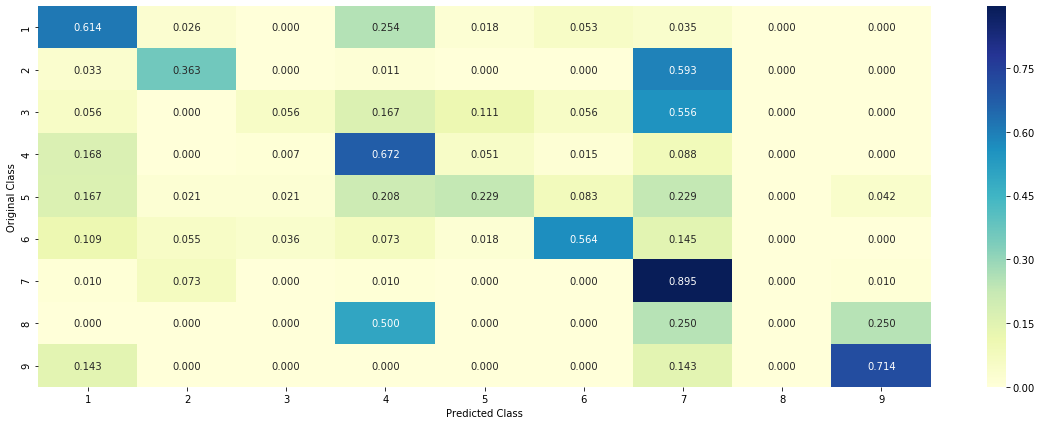

In [205]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(cv_x_onehotCoding, cv_y,
                                  train_x_onehotCoding, train_y, 
                                  test_x_onehotCoding, test_y, clf)

<h4> Feature Importance</h4>

In [0]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5> Correctly Classified point</h5>

In [143]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0],
                     test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index],
                     no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0119 0.0175 0.0055 0.9264 0.0114 0.0056 0.0126 0.0052 0.0039]]
Actual Class : 4
--------------------------------------------------
66 Text feature [genotype] present in test data point [True]
103 Text feature [rich] present in test data point [True]
139 Text feature [soon] present in test data point [True]
143 Text feature [encodes] present in test data point [True]
156 Text feature [upstream] present in test data point [True]
157 Text feature [flow] present in test data point [True]
199 Text feature [explore] present in test data point [True]
463 Text feature [adults] present in test data point [True]
Out of the top  500  features  8 are present in query point


<h5> Incorrectly Classified point</h5>

In [144]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1739 0.0029 0.002  0.6602 0.1464 0.0075 0.0023 0.0036 0.0013]]
Actual Class : 4
--------------------------------------------------
37 Text feature [helicase] present in test data point [True]
63 Text feature [easily] present in test data point [True]
98 Text feature [spatial] present in test data point [True]
109 Text feature [localized] present in test data point [True]
143 Text feature [encodes] present in test data point [True]
144 Text feature [excess] present in test data point [True]
263 Text feature [canada] present in test data point [True]
268 Text feature [abolishing] present in test data point [True]
269 Text feature [clinicians] present in test data point [True]
275 Text feature [synthesis] present in test data point [True]
320 Text feature [396] present in test data point [True]
344 Text feature [information] present in test data point [True]
370 Text feature [phrg] present in test data point [True]
Out of the top  500

<h3> Without Class balancing</h3>

<h4> Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.4395190222240433
for alpha = 1e-05
Log Loss : 1.4613951945118617
for alpha = 0.0001
Log Loss : 1.392640595913179
for alpha = 0.001
Log Loss : 1.2521811628755943
for alpha = 0.01
Log Loss : 1.349151219922669
for alpha = 0.1
Log Loss : 1.457591708320943
for alpha = 1
Log Loss : 1.5902258764770603


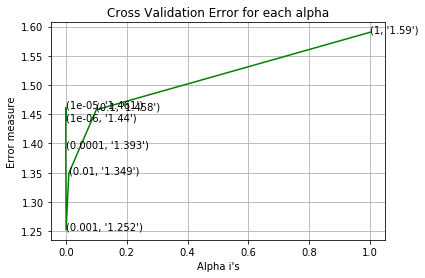

For values of best alpha =  0.001 The train log loss is: 0.6257422677412771
For values of best alpha =  0.001 The cross validation log loss is: 1.2521811628755943
For values of best alpha =  0.001 The test log loss is: 1.1306020069615057


In [0]:

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots(figsize = (12, 7))
ax.plot(alpha, cv_log_error_array)
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
# plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [242]:
table = table.append(pd.DataFrame([["Logistic Regresion(Imbalanced) + BOW", 0.6247, 1.2521, 1.1306, "37.40%", "37.5%", ".001"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1
0,KNN,0.7986,1.1254,1.0257,39.84%,37.59%,31
0,Logistic Regresion(Balanced) + BOW,0.5787,1.1659,0.9792,37.59%,37.74%,0.001
0,Logistic Regresion(Imbalanced) + BOW,0.6247,1.2521,1.1306,37.40%,37.5%,.001


<h4> Testing model with best hyper parameters</h4>

Log loss : 1.1972546914896462
Number of mis-classified points : 0.37406015037593987
Number of mis-classified points : 0.3112781954887218
-------------------- Confusion matrix --------------------


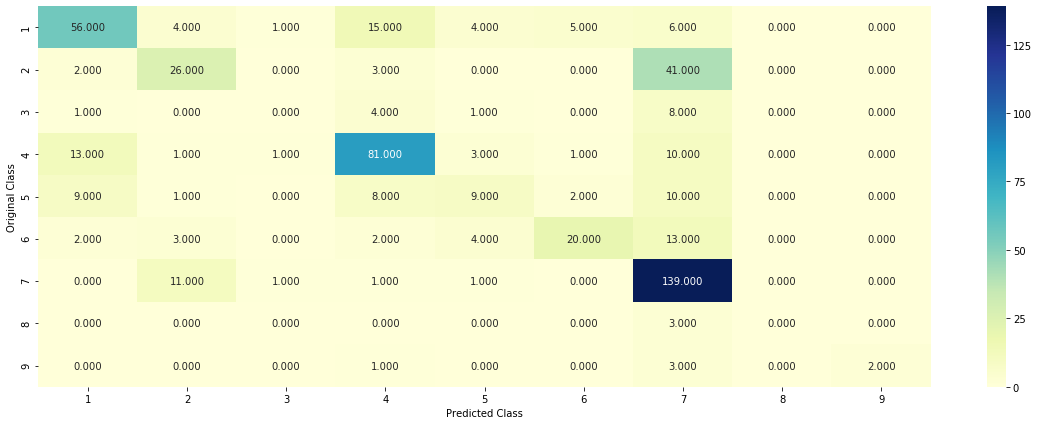

-------------------- Precision matrix (Columm Sum=1) --------------------


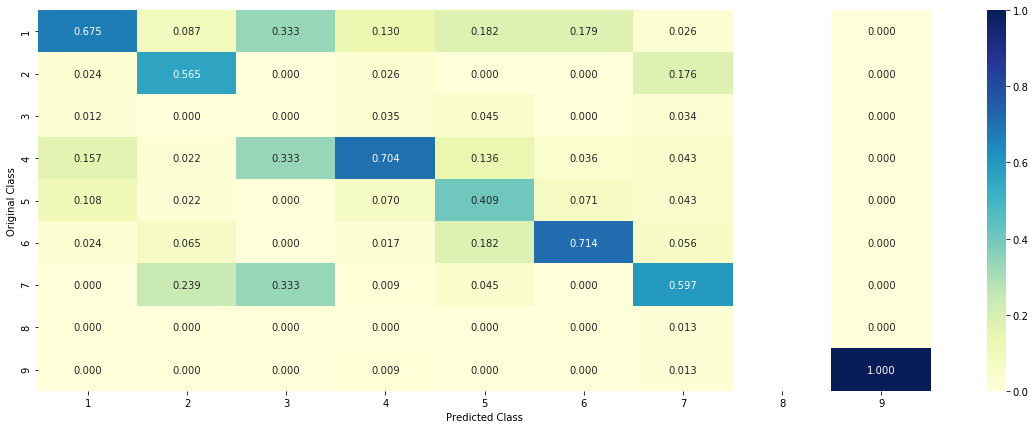

-------------------- Recall matrix (Row sum=1) --------------------


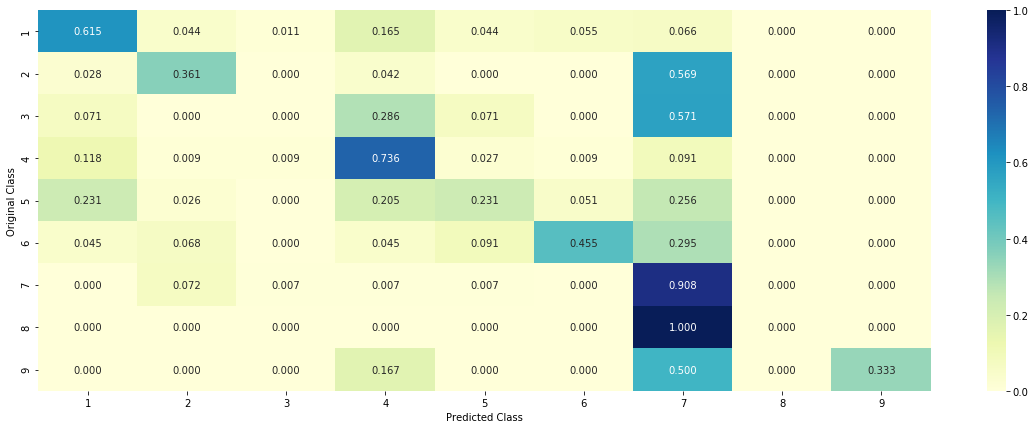

-------------------- Confusion matrix --------------------


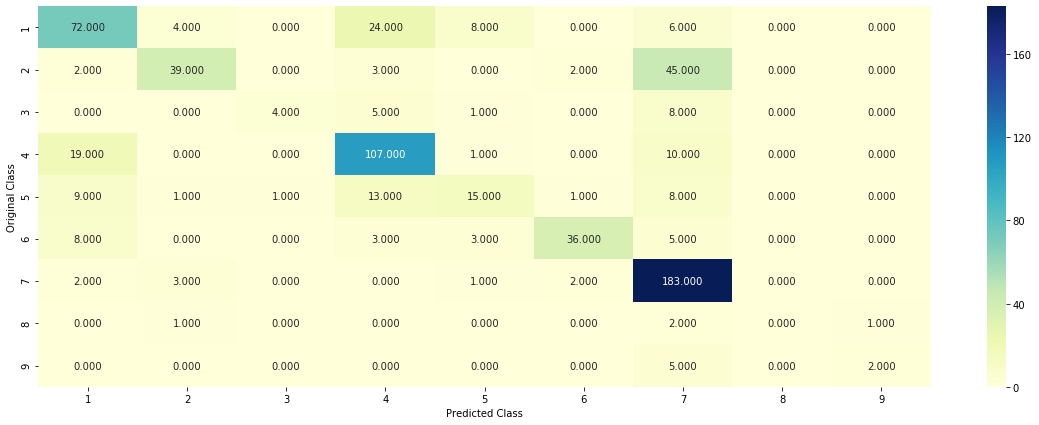

-------------------- Precision matrix (Columm Sum=1) --------------------


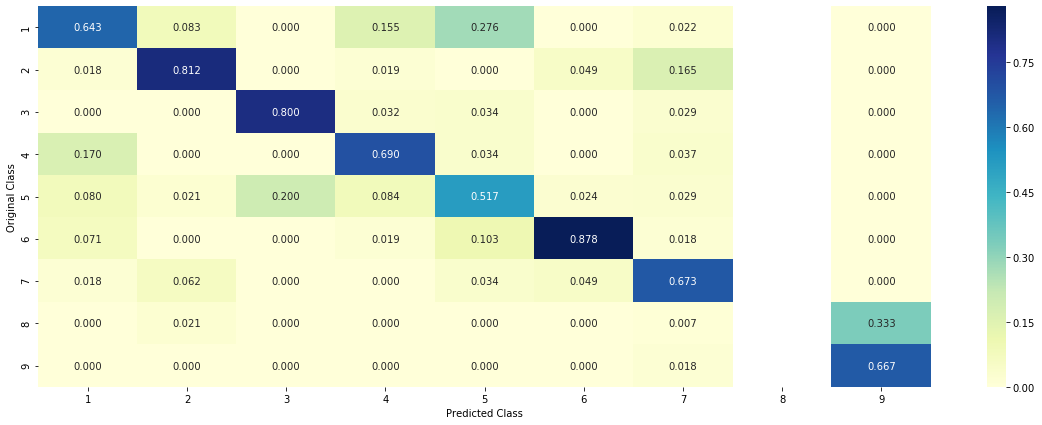

-------------------- Recall matrix (Row sum=1) --------------------


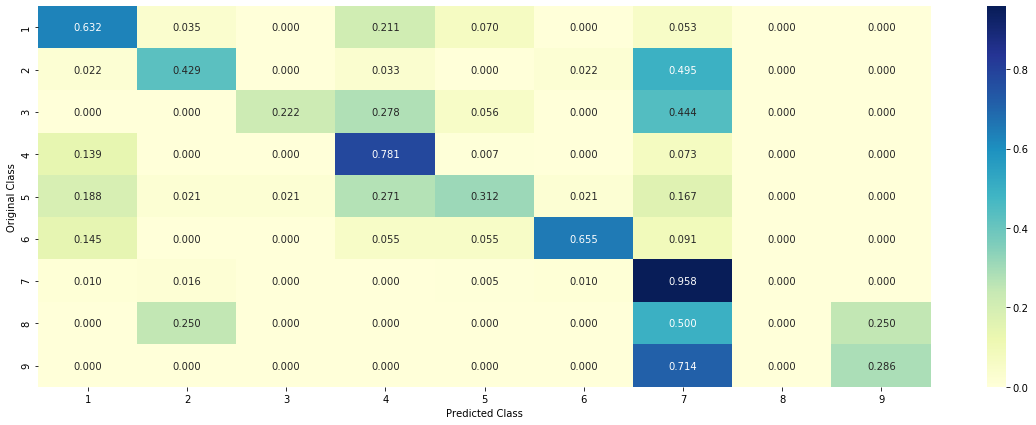

In [145]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(cv_x_onehotCoding, cv_y,
                                  train_x_onehotCoding, train_y, 
                                  test_x_onehotCoding, test_y, clf)

<h4>Feature Importance, Correctly Classified point</h4>

In [148]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0191 0.0214 0.0078 0.8811 0.0143 0.0124 0.0373 0.0046 0.0019]]
Actual Class : 4
--------------------------------------------------
90 Text feature [binding] present in test data point [True]
157 Text feature [latter] present in test data point [True]
189 Text feature [show] present in test data point [True]
245 Text feature [pymol] present in test data point [True]
277 Text feature [separated] present in test data point [True]
376 Text feature [type] present in test data point [True]
Out of the top  500  features  6 are present in query point


<h4>Feature Importance, Inorrectly Classified point</h4>

In [149]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0557 0.0417 0.0036 0.7195 0.044  0.007  0.1204 0.0044 0.0037]]
Actual Class : 4
--------------------------------------------------
37 Text feature [bioinformatics] present in test data point [True]
43 Text feature [serves] present in test data point [True]
90 Text feature [binding] present in test data point [True]
93 Text feature [cosegregation] present in test data point [True]
157 Text feature [latter] present in test data point [True]
158 Text feature [classification] present in test data point [True]
189 Text feature [show] present in test data point [True]
197 Text feature [1698] present in test data point [True]
236 Text feature [ranged] present in test data point [True]
246 Text feature [helicase] present in test data point [True]
256 Text feature [bridge] present in test data point [True]
313 Text feature [rad51] present in test data point [True]
376 Text feature [type] present in test data point [True]
385 Text feature [m

<h2> Linear Support Vector Machines</h2>

<h3> Hyper paramter tuning</h3>

Log loss : 1.1785503590610453
Number of mis-classified points : 0.37969924812030076
Number of mis-classified points : 0.3157894736842105
-------------------- Confusion matrix --------------------


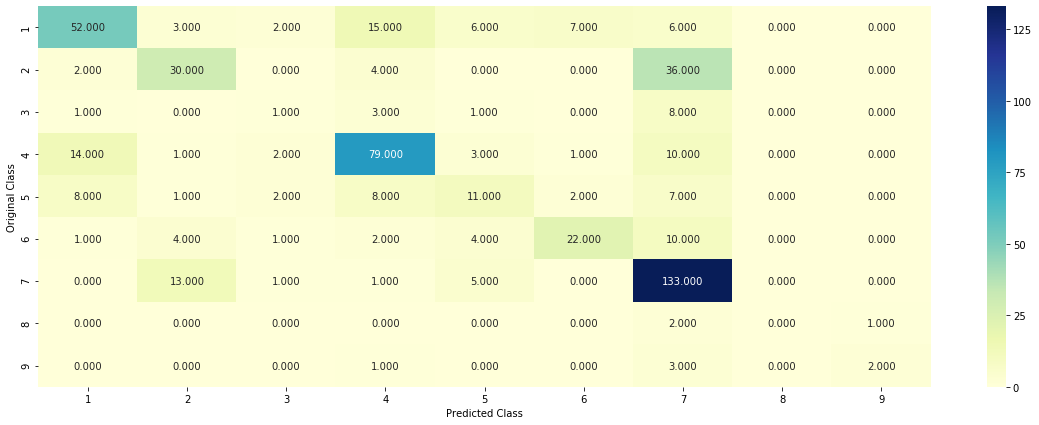

-------------------- Precision matrix (Columm Sum=1) --------------------


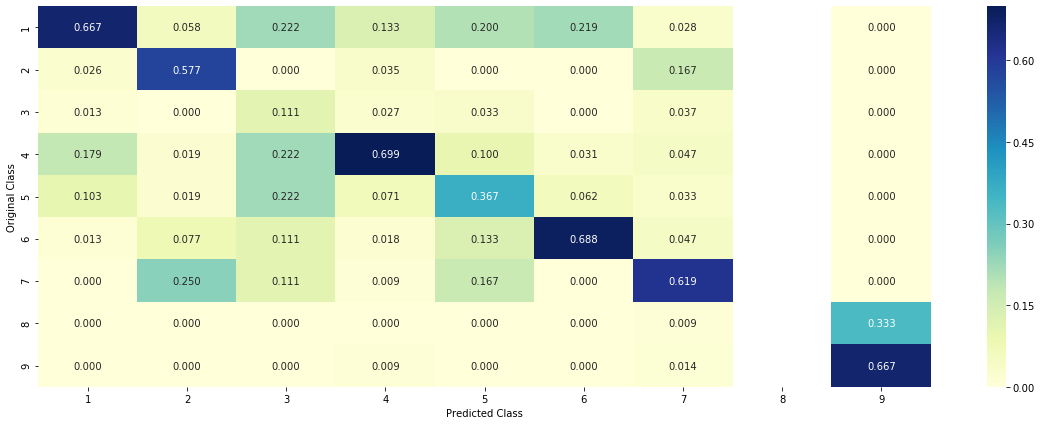

-------------------- Recall matrix (Row sum=1) --------------------


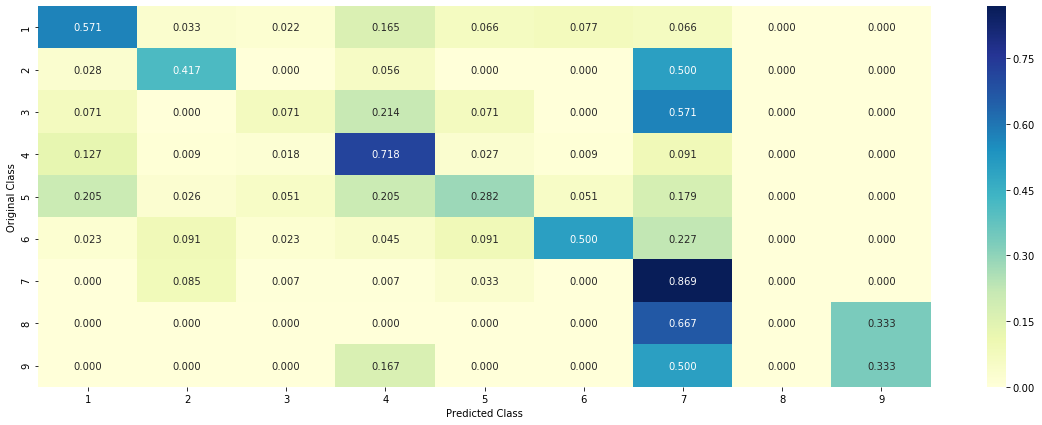

-------------------- Confusion matrix --------------------


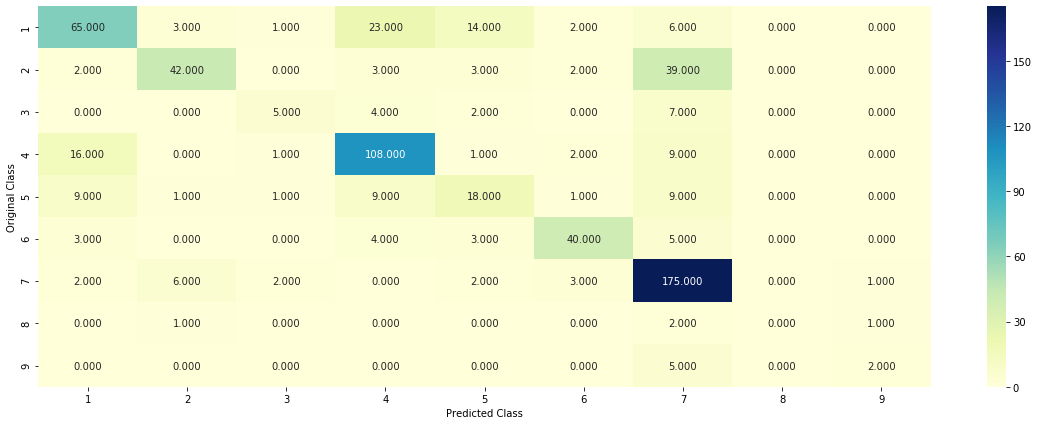

-------------------- Precision matrix (Columm Sum=1) --------------------


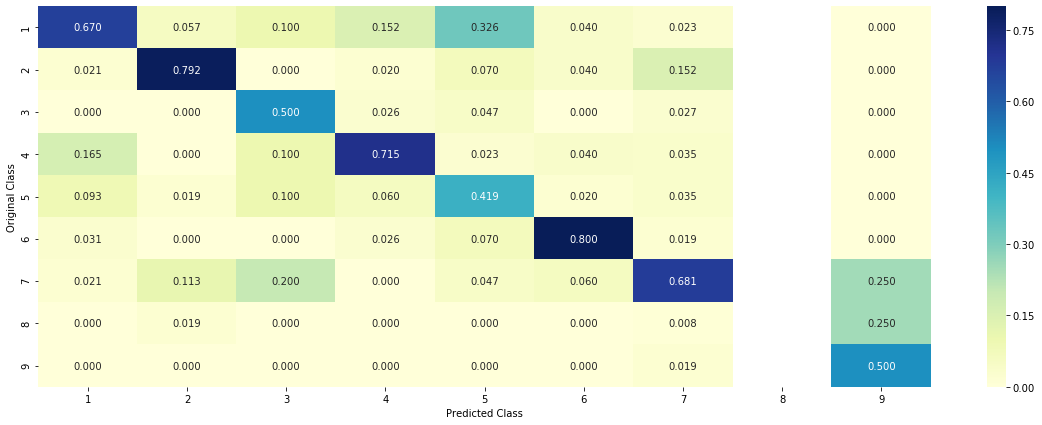

-------------------- Recall matrix (Row sum=1) --------------------


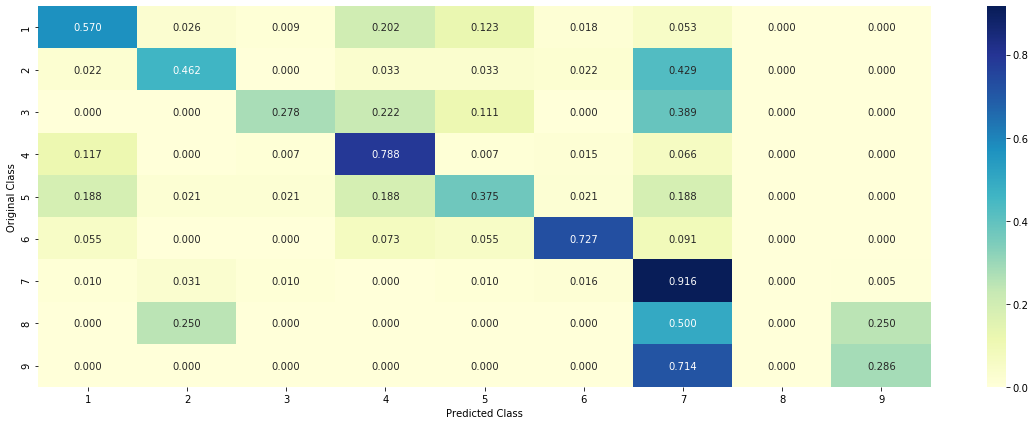

In [151]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(cv_x_onehotCoding, cv_y,
                                  train_x_onehotCoding, train_y, 
                                  test_x_onehotCoding, test_y, clf)

<h3> Feature Importance</h3>

<h4> For Correctly classified point</h4>

In [152]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0191 0.0214 0.0078 0.8811 0.0143 0.0124 0.0373 0.0046 0.0019]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


<h4> For Incorrectly classified point</h4>

In [153]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0557 0.0417 0.0036 0.7195 0.044  0.007  0.1204 0.0044 0.0037]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


<h2>Random Forest Classifier</h2>

<h3> Hyper paramter tuning (With One hot Encoding)</h3>

for n_estimators = 100 and max depth =  5
Log Loss : 1.3193135397739673
for n_estimators = 100 and max depth =  10
Log Loss : 1.2729050095516823
for n_estimators = 200 and max depth =  5
Log Loss : 1.3185357975961516
for n_estimators = 200 and max depth =  10
Log Loss : 1.26635850215167
for n_estimators = 500 and max depth =  5
Log Loss : 1.3164117210630022
for n_estimators = 500 and max depth =  10
Log Loss : 1.259296896731567
for n_estimators = 1000 and max depth =  5
Log Loss : 1.308087036518462
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2532269169342796
for n_estimators = 2000 and max depth =  5
Log Loss : 1.3056140756781305
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2503703254525063


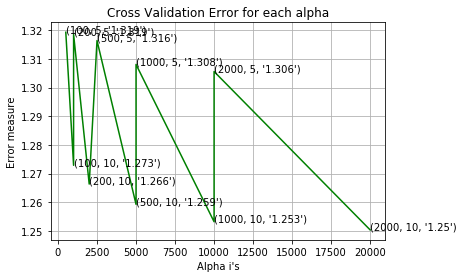

For values of best estimator =  2000 The train log loss is: 0.7196053730718336
For values of best estimator =  2000 The cross validation log loss is: 1.2503703254525063
For values of best estimator =  2000 The test log loss is: 1.1245835561667


In [154]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [243]:
table = table.append(pd.DataFrame([["Random Forest+ OneHotEncoding", 0.7196, 1.2503, 1.245, "40.78%", "38.34%", "2000"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1
0,KNN,0.7986,1.1254,1.0257,39.84%,37.59%,31
0,Logistic Regresion(Balanced) + BOW,0.5787,1.1659,0.9792,37.59%,37.74%,0.001
0,Logistic Regresion(Imbalanced) + BOW,0.6247,1.2521,1.1306,37.40%,37.5%,.001
0,Random Forest+ OneHotEncoding,0.7196,1.2503,1.2450,40.78%,38.34%,2000


<h3> Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.2503703254525063
Number of mis-classified points : 0.40789473684210525
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix --------------------


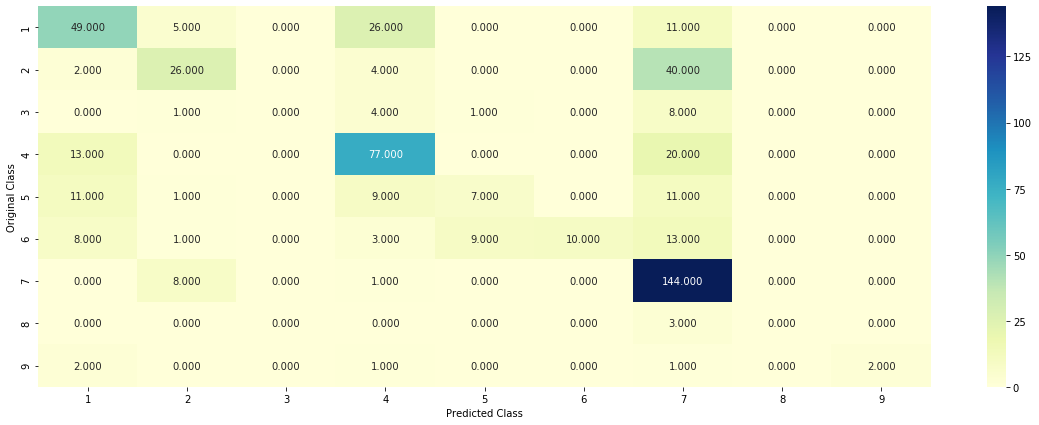

-------------------- Precision matrix (Columm Sum=1) --------------------


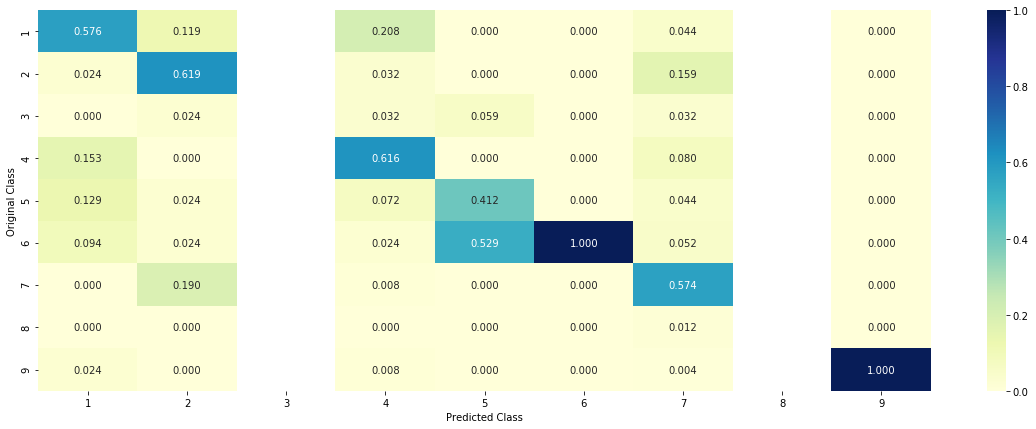

-------------------- Recall matrix (Row sum=1) --------------------


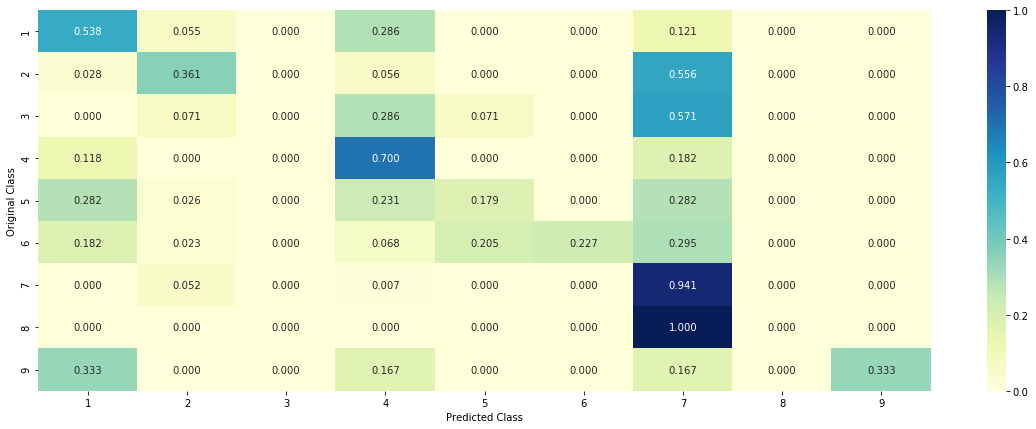

-------------------- Confusion matrix --------------------


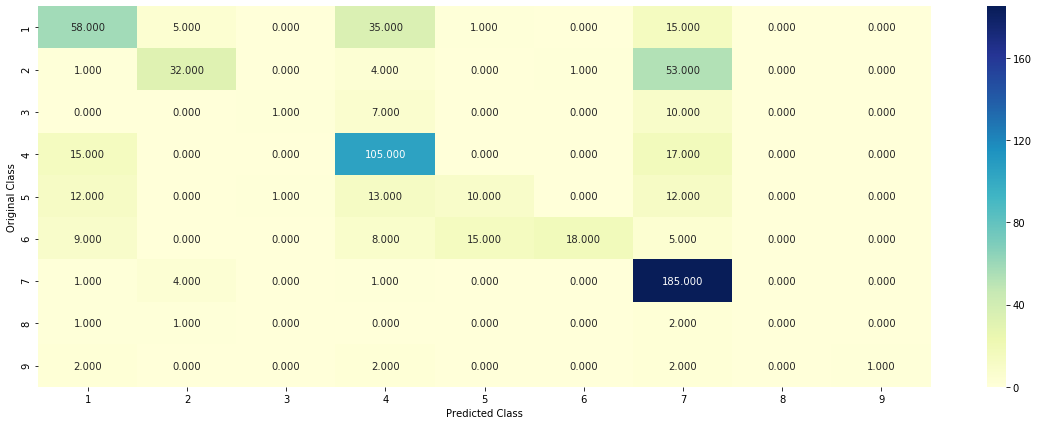

-------------------- Precision matrix (Columm Sum=1) --------------------


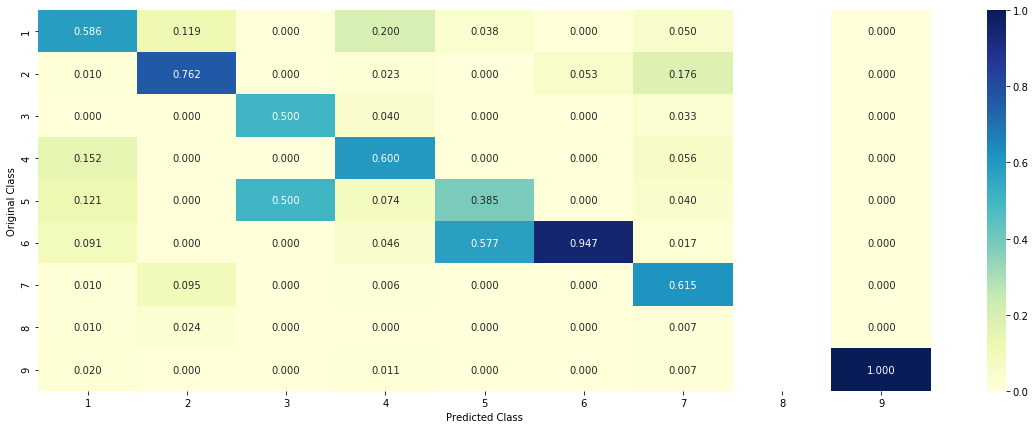

-------------------- Recall matrix (Row sum=1) --------------------


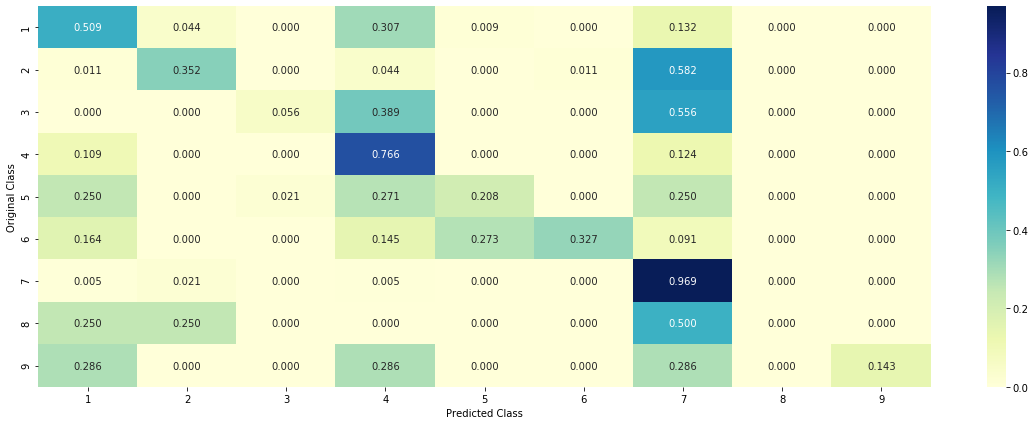

In [155]:

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(cv_x_onehotCoding, cv_y,
                                  train_x_onehotCoding, train_y, 
                                  test_x_onehotCoding, test_y, clf)

<h3> Feature Importance</h3>

<h4> Correctly Classified point</h4>

In [156]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1845 0.0733 0.0244 0.4347 0.0588 0.0485 0.1613 0.0062 0.0084]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
4 Text feature [phosphorylation] present in test data point [True]
6 Text feature [activation] present in test data point [True]
7 Text feature [missense] present in test data point [True]
9 Text feature [signaling] present in test data point [True]
11 Text feature [treatment] present in test data point [True]
12 Text feature [activated] present in test data point [True]
15 Text feature [nonsense] present in test data point [True]
17 Text feature [function] present in test data point [True]
18 Text feature [cells] present in test data point [True]
20 Text feature [functional] present in test data point [True]
21 Text feature [oncogenic] present in test data point [True]
22 Text feature

<h4> Inorrectly Classified point</h4>

In [157]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1612 0.0114 0.0166 0.6056 0.1424 0.039  0.0156 0.0038 0.0043]]
Actuall Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
4 Text feature [phosphorylation] present in test data point [True]
5 Text feature [suppressor] present in test data point [True]
6 Text feature [activation] present in test data point [True]
7 Text feature [missense] present in test data point [True]
8 Text feature [constitutive] present in test data point [True]
9 Text feature [signaling] present in test data point [True]
14 Text feature [brca1] present in test data point [True]
15 Text feature [nonsense] present in test data point [True]
17 Text feature [function] present in test data point [True]
18 Text feature [cells] present in test data point [True]
20 Text feature [functional] present in test data point [True]
22 Text feature 

<h3> Hyper paramter tuning (With Response Coding)</h3>

In [158]:

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.3030408496618233
for n_estimators = 10 and max depth =  3
Log Loss : 1.952382525036397
for n_estimators = 10 and max depth =  5
Log Loss : 1.3984986321432358
for n_estimators = 10 and max depth =  10
Log Loss : 1.9525231975308333
for n_estimators = 50 and max depth =  2
Log Loss : 1.8706673440937351
for n_estimators = 50 and max depth =  3
Log Loss : 1.6120957356596464
for n_estimators = 50 and max depth =  5
Log Loss : 1.3812660167327822
for n_estimators = 50 and max depth =  10
Log Loss : 2.022222354335638
for n_estimators = 100 and max depth =  2
Log Loss : 1.6473865084801567
for n_estimators = 100 and max depth =  3
Log Loss : 1.603541365877185
for n_estimators = 100 and max depth =  5
Log Loss : 1.3727260418413927
for n_estimators = 100 and max depth =  10
Log Loss : 1.8698770218497747
for n_estimators = 200 and max depth =  2
Log Loss : 1.6947128361810944
for n_estimators = 200 and max depth =  3
Log Loss : 1.584190405512571
f

In [244]:
table = table.append(pd.DataFrame([["Random Forest + ResponseCOding", 0.0507, 1.3727, 1.3115, "47.93%", "49.17%", "100"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1
0,KNN,0.7986,1.1254,1.0257,39.84%,37.59%,31
0,Logistic Regresion(Balanced) + BOW,0.5787,1.1659,0.9792,37.59%,37.74%,0.001
0,Logistic Regresion(Imbalanced) + BOW,0.6247,1.2521,1.1306,37.40%,37.5%,.001
0,Random Forest+ OneHotEncoding,0.7196,1.2503,1.2450,40.78%,38.34%,2000
0,Random Forest + ResponseCOding,0.0507,1.3727,1.3115,47.93%,49.17%,100


<h3>4.5.4. Testing model with best hyper parameters (Response Coding)</h3>

Log loss : 1.3727260418413927
Number of mis-classified points : 0.4793233082706767
Number of mis-classified points : 0.4917293233082707
-------------------- Confusion matrix --------------------


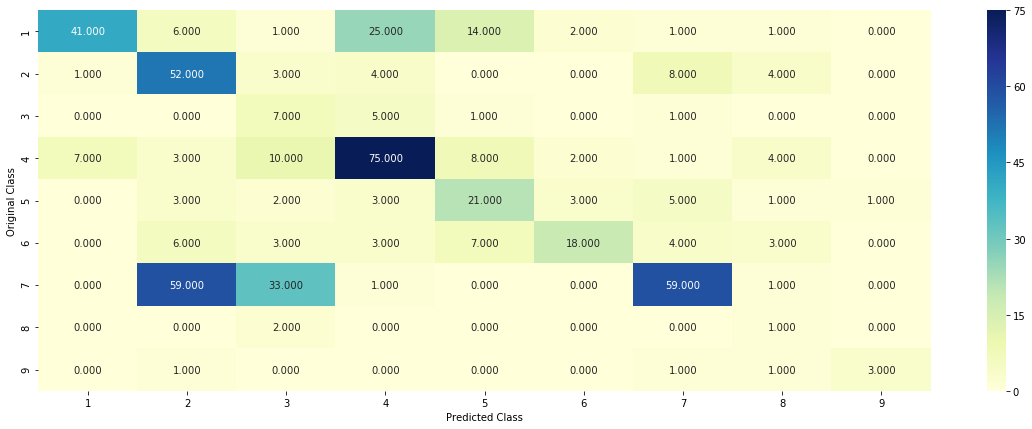

-------------------- Precision matrix (Columm Sum=1) --------------------


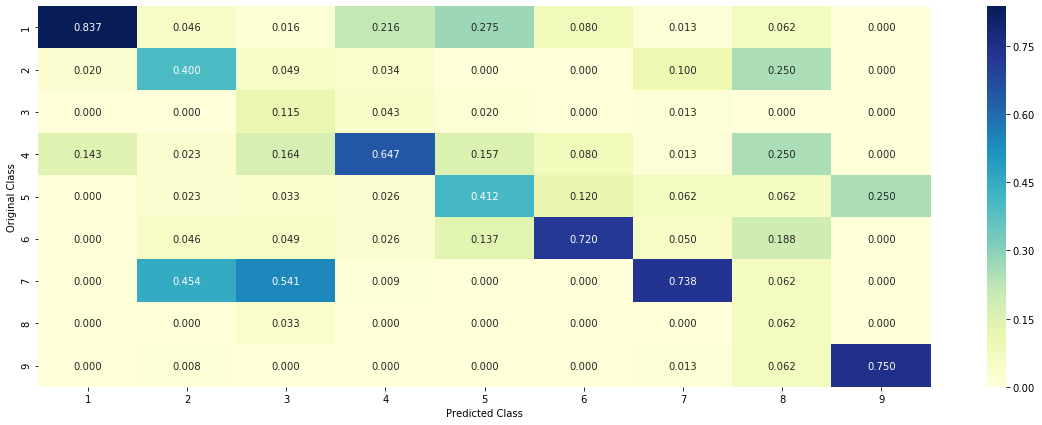

-------------------- Recall matrix (Row sum=1) --------------------


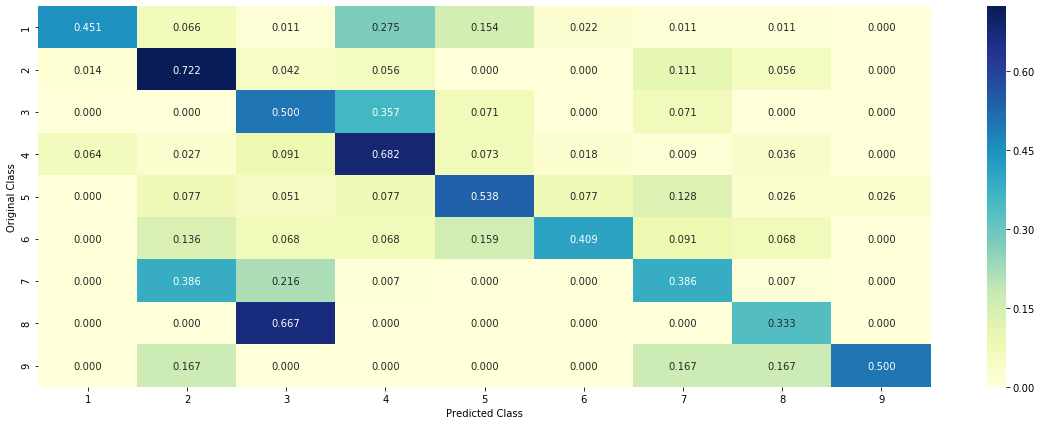

-------------------- Confusion matrix --------------------


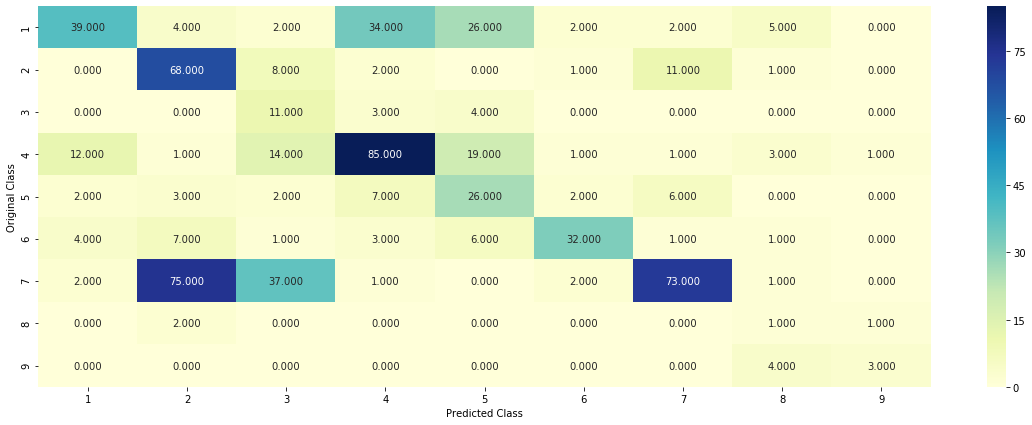

-------------------- Precision matrix (Columm Sum=1) --------------------


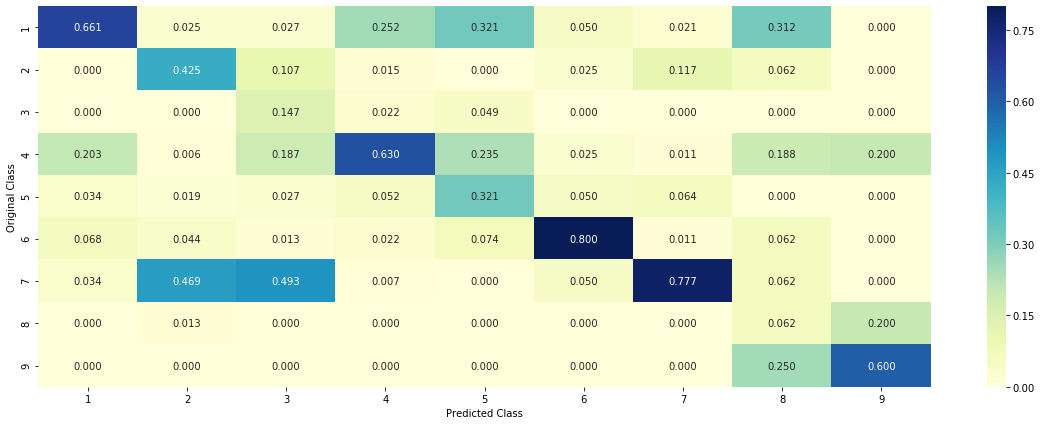

-------------------- Recall matrix (Row sum=1) --------------------


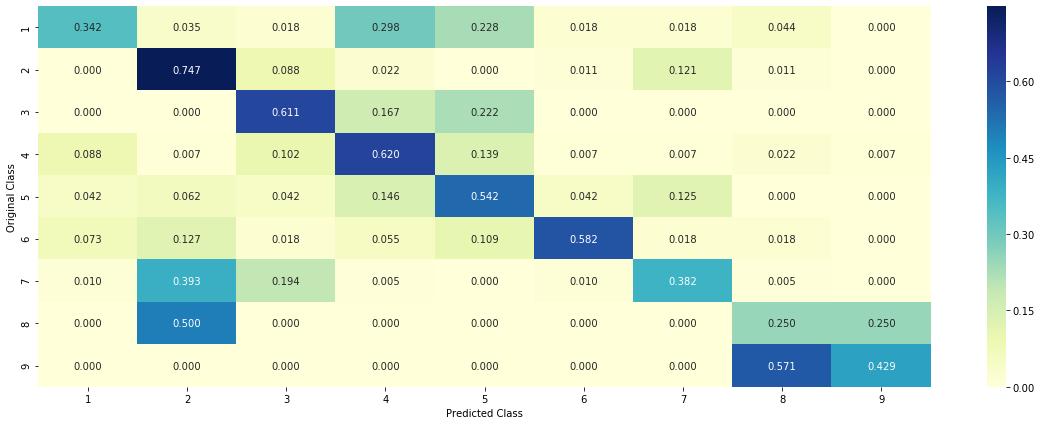

In [159]:

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(cv_x_responseCoding, cv_y,
                                  train_x_responseCoding, train_y, 
                                  test_x_responseCoding, test_y, clf)


<h3> Feature Importance</h3>

<h4> Correctly Classified point</h4>

In [160]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.0704 0.0352 0.1514 0.503  0.047  0.0384 0.0134 0.0865 0.0548]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h4>4.5.5.2. Incorrectly Classified point</h4>

In [161]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 5
Predicted Class Probabilities: [[0.0403 0.0061 0.0887 0.0413 0.572  0.2398 0.0028 0.0035 0.0055]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h2>Stack the models </h2>

<h3>testing with hyper parameter tuning</h3>

In [165]:
from mlxtend.classifier import StackingClassifier

In [166]:
#logistic
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
#SVM
clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

# Naive BAYES
clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = SGDClassifier(loss = "log", alpha = i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.17
Support vector machines : Log Loss: 1.74
Naive Bayes : Log Loss: 1.35
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.546
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.273
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.234
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.580
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.926
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.101


<h3> testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 2.1008334129777255
Log loss (CV) on the stacking classifier : 2.1011408496158444
Log loss (test) on the stacking classifier : 2.100990274124907
Number of missclassified point : 0.7127819548872181
-------------------- Confusion matrix --------------------


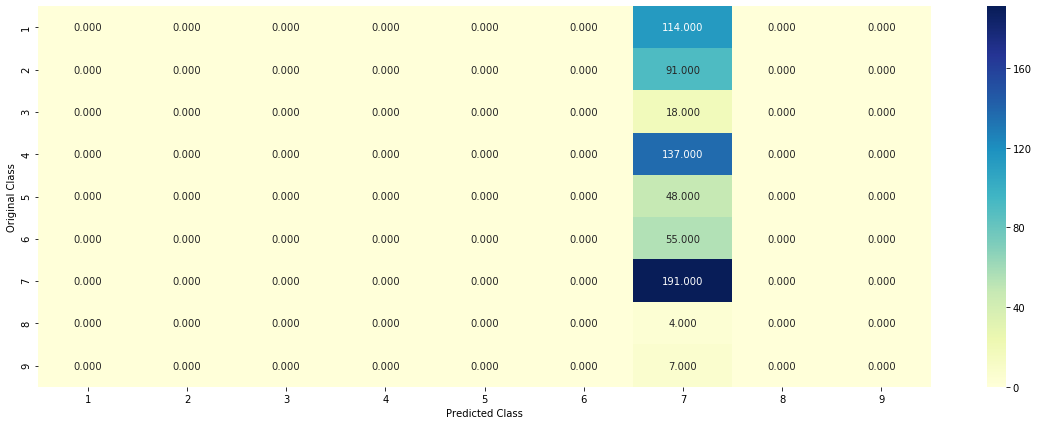

-------------------- Precision matrix (Columm Sum=1) --------------------


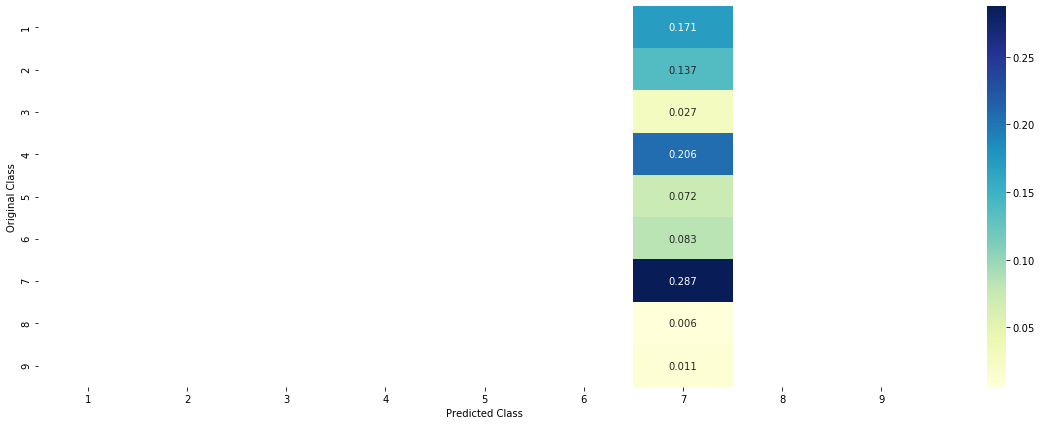

-------------------- Recall matrix (Row sum=1) --------------------


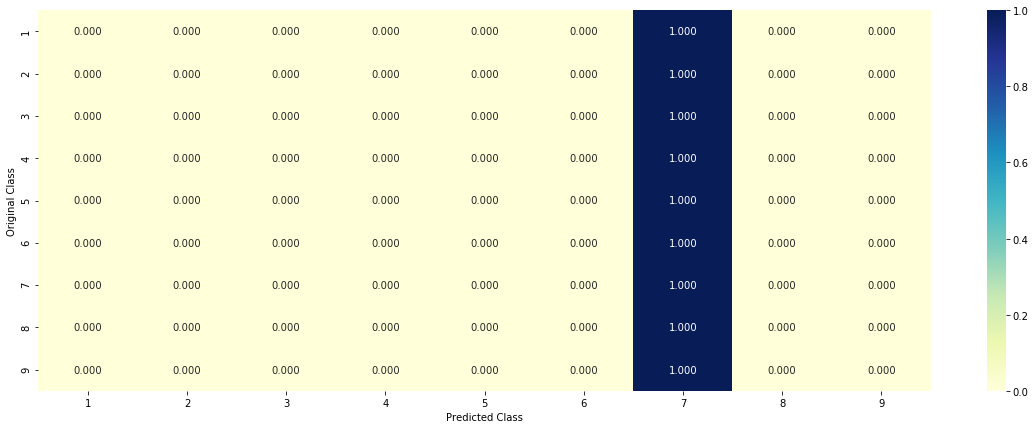

In [167]:
log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3>Maximum Voting classifier </h3>

In [245]:
table = table.append(pd.DataFrame([["Maximum Voting Classifier", 0.8971, 1.2649, 1.1641, "38.03%", "---", "--"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1
0,KNN,0.7986,1.1254,1.0257,39.84%,37.59%,31
0,Logistic Regresion(Balanced) + BOW,0.5787,1.1659,0.9792,37.59%,37.74%,0.001
0,Logistic Regresion(Imbalanced) + BOW,0.6247,1.2521,1.1306,37.40%,37.5%,.001
0,Random Forest+ OneHotEncoding,0.7196,1.2503,1.2450,40.78%,38.34%,2000
0,Random Forest + ResponseCOding,0.0507,1.3727,1.3115,47.93%,49.17%,100
0,Maximum Voting Classifier,0.8971,1.2649,1.1641,38.03%,---,--


Log loss (train) on the VotingClassifier : 0.8971855223919672
Log loss (CV) on the VotingClassifier : 1.2649774262154305
Log loss (test) on the VotingClassifier : 1.164123480860003
Number of missclassified point : 0.32030075187969925
-------------------- Confusion matrix --------------------


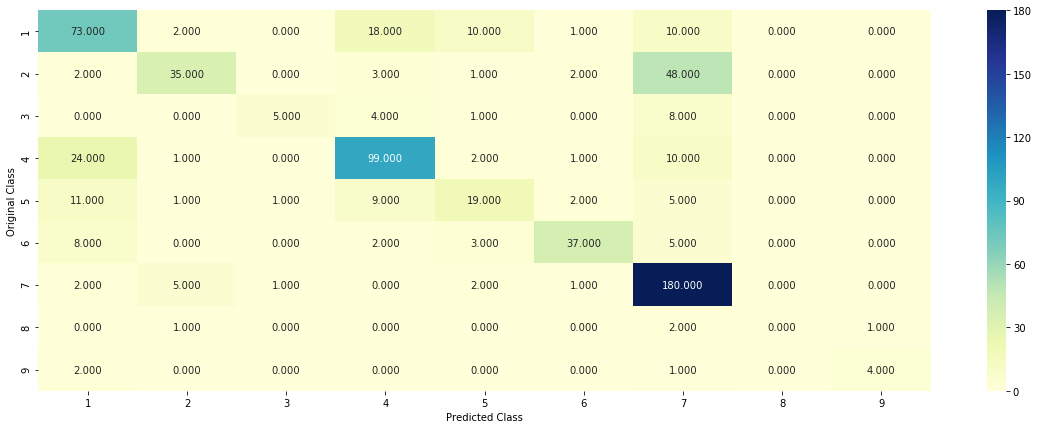

-------------------- Precision matrix (Columm Sum=1) --------------------


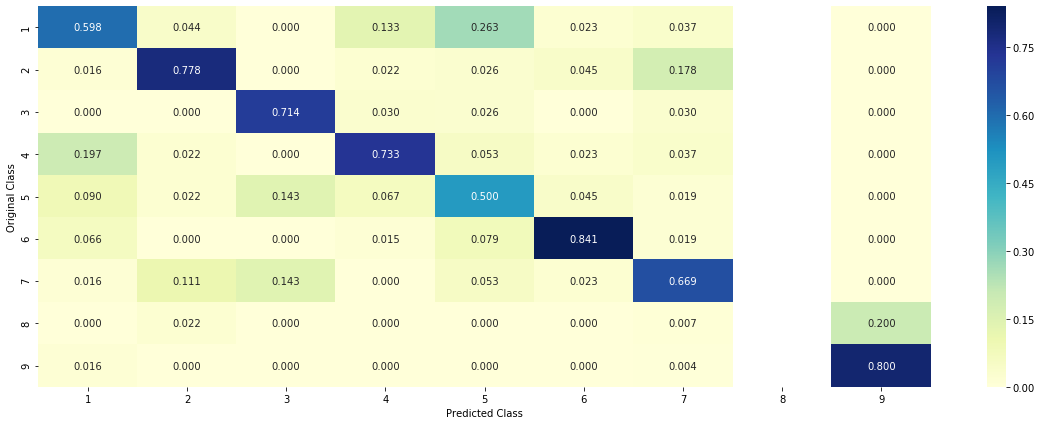

-------------------- Recall matrix (Row sum=1) --------------------


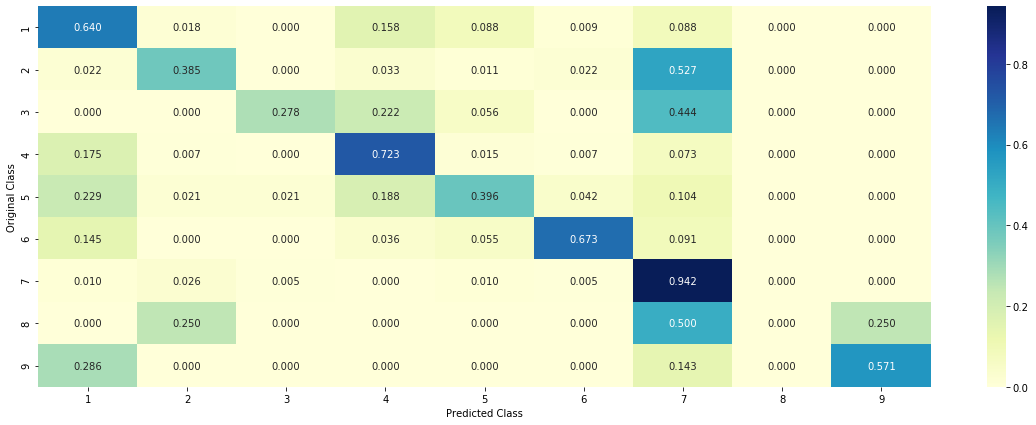

In [169]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# TF-IDF

### Gene Feature

In [172]:
result = pd.merge(data, data_text,on='ID', how='left')
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

x_train, x_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

In [173]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = x_train[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = x_train.loc[(x_train['Class']==k) & (x_train[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)   
    value_count = x_train[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [174]:
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_test))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [175]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

### Variation Feature

In [176]:
alpha = 1

# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))

# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_test))

# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [177]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

### Text Feature

In [178]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary


import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding


In [179]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer()
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 131605


In [180]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [181]:
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])

In [183]:
gene_variation = []

for gene in data['Gene'].values:
    gene_variation.append(gene)

for variation in data['Variation'].values:
    gene_variation.append(variation)

In [184]:
tfidfVectorizer = TfidfVectorizer(max_features=1000)
text2 = tfidfVectorizer.fit_transform(gene_variation)
gene_variation_features = tfidfVectorizer.get_feature_names()

train_text = tfidfVectorizer.transform(x_train['TEXT'])
test_text = tfidfVectorizer.transform(x_test['TEXT'])
cv_text = tfidfVectorizer.transform(x_cv['TEXT'])

### Stack above features

In [185]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

# Adding the train_text feature
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text))
train_x_onehotCoding = hstack((train_x_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(x_train['Class']))

# Adding the test_text feature
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text))
test_x_onehotCoding = hstack((test_x_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(x_test['Class']))

# Adding the cv_text feature
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text))
cv_x_onehotCoding = hstack((cv_x_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(x_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [186]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 134797)
(number of data points * number of features) in test data =  (665, 134797)
(number of data points * number of features) in cross validation data = (532, 134797)


In [187]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## LOGISTIC REGRESSION

In [188]:
alpha = [10 ** x for x in range(-6, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



for alpha = 1e-06
Log Loss : 1.0693015345662382
for alpha = 1e-05
Log Loss : 1.0068929540709204
for alpha = 0.0001
Log Loss : 0.9523869470558654
for alpha = 0.001
Log Loss : 1.0143386482669865
for alpha = 0.01
Log Loss : 1.2496668009731777
for alpha = 0.1
Log Loss : 1.6031529470777666
for alpha = 1
Log Loss : 1.7094283083983202
for alpha = 10
Log Loss : 1.7202514746726665
for alpha = 100
Log Loss : 1.7213826557823675
for alpha = 1000
Log Loss : 1.7215305192061099


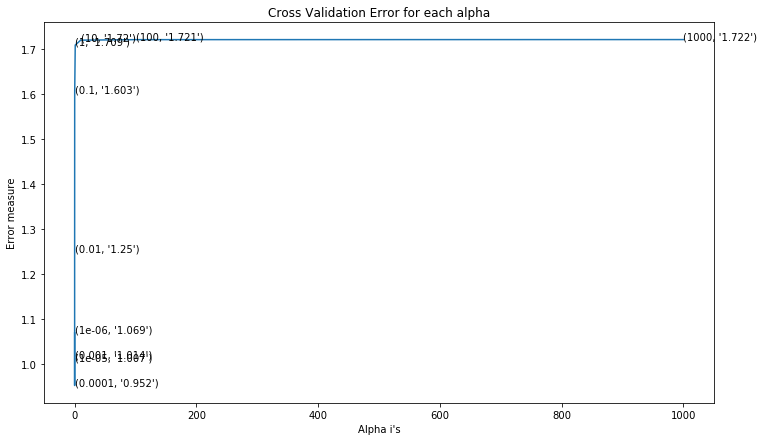

In [189]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(alpha, cv_log_error_array)
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
# plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [190]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                    

In [191]:
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.4512903694517699
For values of best alpha =  0.0001 The cross validation log loss is: 0.9523869470558654
For values of best alpha =  0.0001 The test log loss is: 0.9825130437004649


In [246]:
table = table.append(pd.DataFrame([["Logistic Regression(Balanced) + TfIdf ", 0.4512,0.9523,0.9825, "--%", "--%", "0.0001"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1
0,KNN,0.7986,1.1254,1.0257,39.84%,37.59%,31
0,Logistic Regresion(Balanced) + BOW,0.5787,1.1659,0.9792,37.59%,37.74%,0.001
0,Logistic Regresion(Imbalanced) + BOW,0.6247,1.2521,1.1306,37.40%,37.5%,.001
0,Random Forest+ OneHotEncoding,0.7196,1.2503,1.2450,40.78%,38.34%,2000
0,Random Forest + ResponseCOding,0.0507,1.3727,1.3115,47.93%,49.17%,100
0,Maximum Voting Classifier,0.8971,1.2649,1.1641,38.03%,---,--
0,Logistic Regression(Balanced) + TfIdf,0.4512,0.9523,0.9825,--%,--%,0.0001


In [193]:
alpha = [10 ** x for x in range(-6, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.0784905683162787
for alpha = 1e-05
Log Loss : 1.014518235904847
for alpha = 0.0001
Log Loss : 0.9531074472582383
for alpha = 0.001
Log Loss : 1.0165148948029579
for alpha = 0.01
Log Loss : 1.2353987653562497
for alpha = 0.1
Log Loss : 1.524042712325598
for alpha = 1
Log Loss : 1.6502358601987166
for alpha = 10
Log Loss : 1.6658954989109898
for alpha = 100
Log Loss : 1.6675579452105938
for alpha = 1000
Log Loss : 1.6677481592723766


In [194]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                          

In [195]:
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.44443662052049665
For values of best alpha =  0.0001 The cross validation log loss is: 0.9531074472582383
For values of best alpha =  0.0001 The test log loss is: 0.9837131548618121


In [247]:
table = table.append(pd.DataFrame([["Logistic Regression(Balanced) + TfIdf ", 0.4444,0.9531,0.9837, "--%", "--%", "0.0001"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.3198,1.2268,41.75%,37.44%,0.1
0,KNN,0.7986,1.1254,1.0257,39.84%,37.59%,31
0,Logistic Regresion(Balanced) + BOW,0.5787,1.1659,0.9792,37.59%,37.74%,0.001
0,Logistic Regresion(Imbalanced) + BOW,0.6247,1.2521,1.1306,37.40%,37.5%,.001
0,Random Forest+ OneHotEncoding,0.7196,1.2503,1.2450,40.78%,38.34%,2000
0,Random Forest + ResponseCOding,0.0507,1.3727,1.3115,47.93%,49.17%,100
0,Maximum Voting Classifier,0.8971,1.2649,1.1641,38.03%,---,--
0,Logistic Regression(Balanced) + TfIdf,0.4512,0.9523,0.9825,--%,--%,0.0001
0,Logistic Regression(Balanced) + TfIdf,0.4444,0.9531,0.9837,--%,--%,0.0001


## LINEAR SVM

In [196]:
alpha = [10 ** x for x in range(-6, 4)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.1011309095847395
for alpha = 1e-05
Log Loss : 1.0643304216108058
for alpha = 0.0001
Log Loss : 1.0010598078408355
for alpha = 0.001
Log Loss : 0.9951075923746935
for alpha = 0.01
Log Loss : 1.2509431317620427
for alpha = 0.1
Log Loss : 1.520791696278355
for alpha = 1
Log Loss : 1.6678256278626542
for alpha = 10
Log Loss : 1.6678259255649284
for alpha = 100
Log Loss : 1.6678258821908307
for alpha = 1000
Log Loss : 1.6678162659087932


In [197]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                           

In [198]:
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6945480303539887
For values of best alpha =  0.001 The cross validation log loss is: 1.0165148948029579
For values of best alpha =  0.001 The test log loss is: 1.0300210505072793


In [248]:
table = table.append(pd.DataFrame([["Linera SVM+ TfIdf ", 0.6945,1.0165,1.0300, "--%", "--%", "0.001"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))


## Applying feature engineering

In [199]:
train_x_onehotCodingFE=np.sqrt(train_x_onehotCoding)
test_x_onehotCodingFE=np.sqrt(test_x_onehotCoding)
cv_x_onehotCodingFE=np.sqrt(cv_x_onehotCoding)

for alpha = 1e-06
Log Loss : 1.0119979288742889
for alpha = 1e-05
Log Loss : 1.0108263254519188
for alpha = 0.0001
Log Loss : 0.9507904490878819
for alpha = 0.001
Log Loss : 0.9183989786164584
for alpha = 0.01
Log Loss : 1.015293807903427
for alpha = 0.1
Log Loss : 1.406667281527137
for alpha = 1
Log Loss : 1.7586301566184632
for alpha = 10
Log Loss : 1.7969321441885373
for alpha = 100
Log Loss : 1.799921203803908


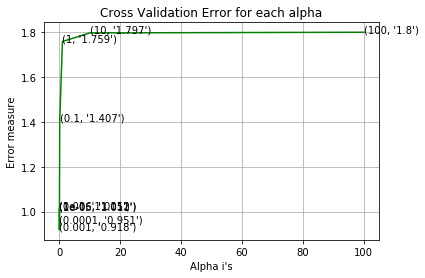

For values of best alpha =  0.001 The train log loss is: 0.5495806558904723
For values of best alpha =  0.001 The cross validation log loss is: 0.9183989786164584
For values of best alpha =  0.001 The test log loss is: 0.9595159447914133


In [200]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCodingFE, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCodingFE, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCodingFE)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCodingFE, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCodingFE, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCodingFE)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCodingFE)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCodingFE)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [249]:
table = table.append(pd.DataFrame([["Logistic Regression(Balanced) + TfIdf + FE", 0.5495,0.91839,0.9595, "--%", "--%", "0.001"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Best HyperParameter"]))

In [250]:
table.reset_index(drop = True, inplace = True)
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Best HyperParameter
0,Naive Bayes,0.8827,1.31980,1.2268,41.75%,37.44%,0.1
1,KNN,0.7986,1.12540,1.0257,39.84%,37.59%,31
2,Logistic Regresion(Balanced) + BOW,0.5787,1.16590,0.9792,37.59%,37.74%,0.001
3,Logistic Regresion(Imbalanced) + BOW,0.6247,1.25210,1.1306,37.40%,37.5%,.001
4,Random Forest+ OneHotEncoding,0.7196,1.25030,1.2450,40.78%,38.34%,2000
5,Random Forest + ResponseCOding,0.0507,1.37270,1.3115,47.93%,49.17%,100
6,Maximum Voting Classifier,0.8971,1.26490,1.1641,38.03%,---,--
7,Logistic Regression(Balanced) + TfIdf,0.4512,0.95230,0.9825,--%,--%,0.0001
8,Logistic Regression(Balanced) + TfIdf,0.4444,0.95310,0.9837,--%,--%,0.0001
9,Linera SVM+ TfIdf,0.6945,1.01650,1.0300,--%,--%,0.001
